In [22]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from sklearn.metrics import r2_score
import os
import time
os.environ["PATH"] += "/home/dalakoti/geppy"
import operator
import random
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, SGDRegressor
from scipy.signal import savgol_filter
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer,QuantileTransformer, RobustScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression,mutual_info_regression, SelectFromModel
import pickle
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Activation, Dropout, GaussianNoise, Conv2D, MaxPooling2D, Flatten, Conv1D,MaxPooling1D
from keras.losses import logcosh
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from sklearn.svm import SVR
import glob
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.model_selection import GridSearchCV, KFold

from keras import optimizers
from multiprocessing import Pool, Process
from keras import regularizers, Input, optimizers, layers
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
import math
import xgboost as xgb
#from numpy import exp


In [4]:
def read_data(loc,d,delU):
    Gij = np.loadtxt(loc+'/Gij_'+d+'.dat')
    Tij = np.loadtxt(loc+'/Tij_'+d+'.dat')
    K   = np.loadtxt(loc+'/k-eps_'+d+'.dat')    
    meanVelGrad = np.loadtxt(loc+'/mean_vel_grad_'+d+'.dat')
    Lij = np.loadtxt(loc+'/lambda_'+d+'.dat')
    Reyn = np.loadtxt(loc+'/Reyn_'+d+'.dat')
    rho = np.loadtxt(loc+'/rho_'+d+'.dat')
    mv = np.loadtxt(loc+'/mean_vel_'+d+'.dat')
    
    mvgg = np.loadtxt(loc+'/mvgg_'+d+'.dat')
    
    idel = [3, 6, 7, 12, 15, 16, 21, 24, 25]
    
    mvgg = np.delete(mvgg,idel,axis=1)
    delta = np.ones(Reyn.shape[0])*np.sum(rho*(delU/2-mv[:,0])*(delU/2+mv[:,0]))*7.34e-6/(0.68*delU**2)
    #delta = np.ones(Reyn.shape[0])*100/np.max(meanVelGrad[:,1])
    x = np.linspace(0,0.0423,576)
    x = x-0.0423/2.0
    eps = np.copy(K[:,1])
    K   = K[:,0]
    index = np.where(K>0.05*np.max(K))
    t_time = np.zeros(576)
    t_time[:] = int(d)*3.38e-7
    
    loend = index[0][0]
    hiend = index[0][-1]
    #loend = 100
    #hiend = 476
    #Gij = Gij[loend:hiend,:]
    #Tij = Tij[loend:hiend,:]
    #meanVelGrad = meanVelGrad[loend:hiend,:]
    #eps = eps[loend:hiend]
    #K = K[loend:hiend] 
    #Lij = Lij[loend:hiend]
    #Reyn = Reyn[loend:hiend]
    #delta = delta[loend:hiend]
    #x = x[loend:hiend]/delta
    #t_time = t_time[loend:hiend]
        
    
    return Gij, Tij, meanVelGrad, eps, K, Lij, Reyn, delta,x,t_time,mvgg

    

    

In [5]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij,eps,K,Lij,x,t_time,mvgg):
        # basis for CNN just, Tij and meanVelGrad\n",
        basis_vect = np.zeros((b.shape[0],3,3,33))
        basis_vect[:,:,:,0] = b
        basis_vect[:,:,:,1] = meanVelGrad
        basis_vect[:,:,:,2] = Lij[:,0,0,None,None]
        basis_vect[:,:,:,3] = Lij[:,0,1,None,None]
        basis_vect[:,:,:,4] = Lij[:,0,2,None,None]
        basis_vect[:,:,:,5] = Lij[:,1,1,None,None]
        basis_vect[:,:,:,6] = Lij[:,1,2,None,None]
        basis_vect[:,:,:,7] = Lij[:,2,2,None,None]
        basis_vect[:,:,:,8] = np.trace(meanVelGrad,axis1=1,axis2=2)[:,None,None]
        basis_vect[:,:,:,9] = np.matmul(np.matmul(meanVelGrad,b),b)
        
        basis_vect[:,:,:,10] = np.matmul(np.matmul(np.transpose(meanVelGrad,(0,2,1)),Lij),meanVelGrad)

        #basis_vect[:,:,:,8] = np.trace(meanVelGrad,axis1=1,axis2=2)[:,None,None]
        #basis_vect[:,:,:,9] = np.trace(np.matmul(Tij,meanVelGrad),axis1=1,axis2=2)[:,None,None]
        #basis_vect[:,:,:,10] = Tij*np.trace(meanVelGrad,axis1=1,axis2=2)[:,None,None]
        basis_vect[:,:,:,11] = np.trace(Lij,axis1=1,axis2=2)[:,None,None]      

        basis_vect[:,:,:,12] = np.transpose(meanVelGrad,(0,2,1))
        basis_vect[:,:,:,13] = np.matmul(Lij,meanVelGrad)
        basis_vect[:,:,:,14] = np.matmul(meanVelGrad,Lij)
        basis_vect[:,:,:,15] = np.matmul(np.transpose(meanVelGrad,(0,2,1)),Lij)
        basis_vect[:,:,:,16] = np.matmul(Lij,np.transpose(meanVelGrad,(0,2,1)))
        #basis_vect[:,:,:,6] = np.matmul(np.matmul(Lij,meanVelGrad),meanVelGrad)
        #basis_vect[:,:,:,7] = np.matmul(np.matmul(meanVelGrad,meanVelGrad),Lij)
        #basis_vect[:,:,:,8] = np.matmul(np.matmul(Lij,Lij),meanVelGrad)
        #basis_vect[:,:,:,9] = np.matmul(np.matmul(meanVelGrad,Lij),Lij)
        #basis_vect[:,:,:,10] = np.matmul(np.matmul(meanVelGrad,Lij),meanVelGrad)
        #basis_vect[:,:,:,11] = np.matmul(np.matmul(Lij,meanVelGrad),Lij)
        basis_vect[:,:,:,17] = np.matmul(b,meanVelGrad)    
        basis_vect[:,:,:,18] = np.matmul(meanVelGrad,b)
        basis_vect[:,:,:,19] = np.matmul(np.transpose(meanVelGrad,(0,2,1)),b)
        basis_vect[:,:,:,20] = np.matmul(b,np.transpose(meanVelGrad,(0,2,1)))
        
        
        basis_vect[:,:,:,21] = Reyn[:,None,None]
        basis_vect[:,:,:,22] = np.matmul(np.transpose(meanVelGrad,(0,2,1)),Lij)
        basis_vect[:,:,:,23] = K[:,None,None]
        basis_vect[:,:,:,24] = eps[:,None,None]
        basis_vect[:,:,:,25] = b
        
        
        
        #basis_vect[:,:,:,18] = np.trace(basis_vect[:,:,:,1],axis1=1,axis2=2)[:,None,None]\n",
        #basis_vect[:,:,:,19] = np.trace(basis_vect[:,:,:,2],axis1=1,axis2=2)[:,None,None]\n",
        #basis_vect[:,:,:,20] = np.trace(basis_vect[:,:,:,3],axis1=1,axis2=2)[:,None,None]\n",
        #basis_vect[:,:,:,21] = np.trace(basis_vect[:,:,:,4],axis1=1,axis2=2)[:,None,None]\n",
        #basis_vect[:,:,:,22] = np.trace(basis_vect[:,:,:,5],axis1=1,axis2=2)[:,None,None]\n",
        #basis_vect[:,:,:,23] = np.trace(basis_vect[:,:,:,7],axis1=1,axis2=2)[:,None,None]\n",
        #basis_vect[:,:,:,24] = np.matmul(Lij,np.transpose(meanVelGrad,(0,2,1)))\n",
        ##basis_vect[:,:,:,25] = np.matmul(np.transpose(meanVelGrad,(0,2,1)),Lij)\n",
        #basis_vect[:,:,:,26] = np.matmul(Tij,np.transpose(meanVelGrad,(0,2,1)))    \n",
        #basis_vect[:,:,:,27] = np.matmul(np.transpose(meanVelGrad,(0,2,1)),Tij)\n",
        #basis_vect[:,:,:,28] = Lij[0,1]\n",
        #basis_vect[:,:,:,29] = Lij[0,2]\n",
        #basis_vect[:,:,:,30] = K[:,None,None]/eps[:,None,None]\n",
        return basis_vect       
		

In [6]:
def get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij,eps,K,Lij,x,t_time,mvgg):
        # basis for CNN just, Tij and meanVelGrad\n",
        basis_vect = np.zeros((b.shape[0],3,3,33))
        basis_vect[:,:,:,0] = b
        basis_vect[:,:,:,1] = meanVelGrad
        basis_vect[:,:,:,2] = Lij[:,0,0,None,None]
        basis_vect[:,:,:,3] = Lij[:,0,1,None,None]
        basis_vect[:,:,:,4] = Lij[:,0,2,None,None]
        basis_vect[:,:,:,5] = Lij[:,1,1,None,None]
        basis_vect[:,:,:,6] = Lij[:,1,2,None,None]
        basis_vect[:,:,:,7] = Lij[:,2,2,None,None]
        basis_vect[:,:,:,8] = np.transpose(meanVelGrad,(0,2,1))
        basis_vect[:,:,:,9] = np.matmul(Lij,meanVelGrad)
        basis_vect[:,:,:,10] = np.matmul(meanVelGrad,Lij)
        basis_vect[:,:,:,11] = np.matmul(np.transpose(meanVelGrad,(0,2,1)),Lij)
        basis_vect[:,:,:,12] = np.matmul(Lij,np.transpose(meanVelGrad,(0,2,1)))
        basis_vect[:,:,:,13] = np.matmul(b,meanVelGrad)    
        basis_vect[:,:,:,14] = np.matmul(meanVelGrad,b)
        basis_vect[:,:,:,15] = np.matmul(np.transpose(meanVelGrad,(0,2,1)),b)
        basis_vect[:,:,:,16] = np.matmul(b,np.transpose(meanVelGrad,(0,2,1)))        
        basis_vect[:,:,:,17] = K[:,None,None]
        basis_vect[:,:,:,18] = eps[:,None,None]
        basis_vect[:,:,:,19] = Reyn[:,None,None]
        basis_vect[:,:,:,20] = np.matmul(np.matmul(meanVelGrad,b),b)       
        basis_vect[:,:,:,21] = np.trace(meanVelGrad,axis1=1,axis2=2)[:,None,None]
        basis_vect[:,:,:,22] = np.matmul(np.matmul(np.transpose(meanVelGrad,(0,2,1)),Lij),meanVelGrad)
        return basis_vect       


In [7]:
def get_training_data(dir_loc,normalise=False,normalise_const=True,delU=100):
    
    files = glob.glob(dir_loc+'accu*.dat')
    indexes = [F[-7:-4] for F in files]        
    loindices = np.zeros(len(indexes)+1)
    Gij, Tij , meanVelGrad , eps, K, Lij, Reyn, delta, x, t_time = read_data(dir_loc,indexes[0],delU)
    loindices[1] = K.shape[0]
    
    for i, d in enumerate(indexes[1:-1]):
        Gij1, Tij1 , meanVelGrad1 , eps1, K1, Lij1, Reyn1, delta1, x1, t_time1 = read_data(dir_loc,d,delU)
        loindices[i+2] = loindices[i+1]+K1.shape[0]
        Gij = np.append(Gij,Gij1,axis=0)
        Tij = np.append(Tij,Tij1,axis=0)
        meanVelGrad = np.append(meanVelGrad,meanVelGrad1,axis=0)    
        eps = np.append(eps,eps1,axis=0)
        K = np.append(K,K1,axis=0)
        Lij = np.append(Lij,Lij1,axis=0)
        Reyn = np.append(Reyn,Reyn1,axis=0)
        delta = np.append(delta,delta1,axis=0)
        x = np.append(x,x1,axis=0)
        t_time = np.append(t_time,t_time1,axis=0)
        
        
    loindices[len(indexes)] = loindices[len(indexes)]-1   
    loindices = loindices.astype(int)    
     
    b = np.copy(Tij)
    b[:,0] = b[:,0]-2.0*K/3.0
    b[:,4] = b[:,4]-2.0*K/3.0
    b[:,8] = b[:,8]-2.0*K/3.0
    Gij = np.reshape(Gij,(Gij.shape[0],3,3))
    Tij = np.reshape(Tij,(Tij.shape[0],3,3))
    meanVelGrad = np.reshape(meanVelGrad,(meanVelGrad.shape[0],3,3))
    b = np.reshape(b,(b.shape[0],3,3))
    Lij = np.reshape(Lij,(Lij.shape[0],3,3))

    Sij = np.zeros((b.shape[0],3,3))
    omega = np.zeros((b.shape[0],3,3))
    
    for i in range(Sij.shape[0]):
        Sij[i,:,:] = 0.5*(meanVelGrad[i,:,:]+np.transpose(meanVelGrad[i,:,:]))
        omega[i,:,:] = 0.5*(meanVelGrad[i,:,:]-np.transpose(meanVelGrad[i,:,:]))
        
    b = b/(2.0*K[:,None,None])

    if(normalise):    
        Gij = Gij*K[:,None,None]/eps[:,None,None]
        Tij = Tij/K[:,None,None]
        meanVelGrad = meanVelGrad*K[:,None,None]/eps[:,None,None]
        Sij = Sij*K[:,None,None]/eps[:,None,None]
        omega = omega*K[:,None,None]/eps[:,None,None]
        Lij = Lij*K[:,None,None]
        #t_time = t_time*eps/K
        
    if(normalise_const):               
        Gij = Gij*delta[:,None,None]/delU
        #Gij = Gij*delta[:,None,None]/delU**3        
        Tij = Tij/delU**2
        meanVelGrad = meanVelGrad*delta[:,None,None]/delU
        Sij = Sij*delta[:,None,None]/delU
        omega = omega*delta[:,None,None]/delU
        eps = eps*delta/delU**3
        K = K/delU**2
        Lij = Lij*delU**2
        t_time = t_time*delU/delta
        
        
    
    basis_vect = get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij,eps,K,Lij,x,t_time)
    basis_vect = np.moveaxis(basis_vect,0,-2)
    Gij = np.moveaxis(Gij,0,-1)
    Tij = np.moveaxis(Tij,0,-1)
    Lij = np.moveaxis(Lij,0,-1)
    b = np.moveaxis(b,0,-1)
    meanVelGrad = np.moveaxis(meanVelGrad,0,-1)
    Sij = np.moveaxis(Sij,0,-1)
    omega = np.moveaxis(omega,0,-1)
    
    
        
    return Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K, basis_vect, loindices.astype(int), delta,x


In [8]:
def get_training_data_time(dir_loc,time,normalise=False,normalise_const=True,delU=100):

    files = sorted(glob.glob(dir_loc+'accu*.dat'))
    indexes = [F[-7:-4] for F in files]        
    loindices = np.zeros(len(indexes)+1)
    Gij, Tij , meanVelGrad , eps, K, Lij, Reyn, delta, x, t_time,mvgg = read_data(dir_loc,indexes[time],delU)
    loindices[1] = K.shape[0]
    
    b = np.copy(Tij)
    b[:,0] = b[:,0]-2.0*K/3.0
    b[:,4] = b[:,4]-2.0*K/3.0
    b[:,8] = b[:,8]-2.0*K/3.0
    Gij = np.reshape(Gij,(Gij.shape[0],3,3))
    Tij = np.reshape(Tij,(Tij.shape[0],3,3))
    meanVelGrad = np.reshape(meanVelGrad,(meanVelGrad.shape[0],3,3))
    b = np.reshape(b,(b.shape[0],3,3))
    Lij = np.reshape(Lij,(Lij.shape[0],3,3))

    Sij = np.zeros((b.shape[0],3,3))
    omega = np.zeros((b.shape[0],3,3))
    
    for i in range(Sij.shape[0]):
        Sij[i,:,:] = 0.5*(meanVelGrad[i,:,:]+np.transpose(meanVelGrad[i,:,:]))
        omega[i,:,:] = 0.5*(meanVelGrad[i,:,:]-np.transpose(meanVelGrad[i,:,:]))
        
    b = b/(2.0*K[:,None,None])
    if(normalise):    
        Gij = Gij*K[:,None,None]/eps[:,None,None]
        Tij = Tij/K[:,None,None]
        meanVelGrad = meanVelGrad*K[:,None,None]/eps[:,None,None]
        Sij = Sij*K[:,None,None]/eps[:,None,None]
        omega = omega*K[:,None,None]/eps[:,None,None]
        Lij = Lij*K[:,None,None]
    
    if(normalise_const):
        
        Gij = Gij*delta[:,None,None]/delU
        #Gij = Gij*delta[:,None,None]/delU**3        
        Tij = Tij/delU**2
        meanVelGrad = meanVelGrad*delta[:,None,None]/delU
        Sij = Sij*delta[:,None,None]/delU
        omega = omega*delta[:,None,None]/delU
        eps = eps*delta/delU**3
        K = K/delU**2
        Lij = Lij*delU**2
        t_time = t_time*delU/delta

    basis_vect = get_basis_vect(b,Sij,omega,meanVelGrad,Reyn,Tij,eps,K,Lij,x,t_time,mvgg)
    basis_vect = np.moveaxis(basis_vect,0,-2)
    Gij = np.moveaxis(Gij,0,-1)
    Tij = np.moveaxis(Tij,0,-1)
    Lij = np.moveaxis(Lij,0,-1)
    b = np.moveaxis(b,0,-1)
    meanVelGrad = np.moveaxis(meanVelGrad,0,-1)
    Sij = np.moveaxis(Sij,0,-1)
    omega = np.moveaxis(omega,0,-1)
        
    return Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K, basis_vect, loindices.astype(int), delta, x


In [9]:
def drop_correlated(X):
    c = np.corrcoef(X.T)
    c = np.nan_to_num(c)
    
    index = list(np.where(np.triu(c,k=1)>0.99))    
    to_drop = list(set(index[1]))
    
    consts = np.all(X == X[0,:], axis = 0)
    constsi = list(np.where(consts)[0])
    to_drop = list(set(to_drop+constsi))

    
    X_new = np.delete(X,to_drop,axis=1)
    
    
    return X_new, to_drop

In [10]:
def get_CNN_training(direc,ist,nt,stp, delU,nfs,i1,j1):
            Gij, _, _, _, _, _, Lij, _, _, basis_vect, _, _, _ = get_training_data_time(direc,ist,False,False,delU)
            idxs = np.zeros(math.ceil((nt)/stp)+1)
            idxs[0]=0
            X = np.copy(basis_vect[i1,j1,:,0:nfs])
            Y = np.copy(Gij[i1,j1,:])
            j=1
            for i in range(ist+stp,ist+nt,stp):
                idxs[j] = idxs[j-1]+Gij.shape[2]
                Gij, _, _, _, _, _, Lij, _, _, basis_vect, _, _, _ = get_training_data_time(direc,i,False,False,delU)
                X = np.append(X,basis_vect[i1,j1,:,0:nfs],axis=0)
                Y = np.append(Y,Gij[i1,j1,:],axis=0)
                j=j+1
            idxs[j] = X.shape[0]    
            #Only take lambda_kj terms
            if(j1==0):
                X = np.delete(X,(5,6,7),axis=1)
            if(j1==1):
                X = np.delete(X,(2,4,7),axis=1)
            if(j1==2):
                X = np.delete(X,(2,3,5),axis=1)
            
                
            return X,Y,idxs.astype(int)

In [11]:
def scale_data(X_train,X_test, X_val, Y_train, Y_test, Y_val, which):
    
    if(which == 'std'):
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        X_val = sc.transform(X_val)
        Y_train = sc.fit_transform(Y_train.reshape(-1,1))
        Y_test = sc.transform(Y_test.reshape(-1,1))
        Y_val = sc.transform(Y_val.reshape(-1,1))
        return X_train, X_test, X_val, Y_train, Y_test, Y_val
    
    if(which == 'mean'):
        meanX   = np.mean(X_train,axis=0)
        stdX    = np.std(X_train,axis=0)
    
        meanY   = np.mean(Y_train)
        stdY    = np.std(Y_train)
    
        Y_train = (Y_train)/meanY
        Y_test = (Y_test)/meanY
        Y_val   = (Y_val)/meanY
        
        for i in range(X_train.shape[1]):
            X_train[:,i] = (X_train[:,i])/meanX[i]
            X_test[:,i] = (X_test[:,i])/meanX[i]
            X_val[:,i] = (X_val[:,i])/meanX[i]
        return X_train, X_test, X_val, Y_train, Y_test, Y_val
    
    
    if(which=='minmax'):
        minX   = np.min(X_train,axis=(0))
        maxX    = np.max(X_train,axis=(0))
    
        minY   = np.min(Y_train)
        maxY    = np.max(Y_train)
    
        Y_train = (Y_train-minY)/(maxY-minY)
        Y_test = (Y_test-minY)/(maxY-minY)
        Y_val   = (Y_val-minY)/(maxY-minY)
        #Y_train = (Y_train)/(maxY-minY)
        #Y_test = (Y_test)/(maxY-minY)
        #Y_val   = (Y_val)/(maxY-minY)
    
        for i in range(X_train.shape[1]):
            X_train[:,i] = (X_train[:,i]-minX[i])/(maxX[i]-minX[i])
            X_test[:,i] = (X_test[:,i]-minX[i])/(maxX[i]-minX[i])            
            X_val[:,i] = (X_val[:,i]-minX[i])/(maxX[i]-minX[i])
            
        return X_train, X_test, X_val, Y_train, Y_test, Y_val
    
    if(which=='max'):
        maxX    = np.max(np.abs(X_train),axis=(0))
    
        maxY    = np.max(np.abs(Y_train))
    
        Y_train = (Y_train)/(maxY)
        Y_test = (Y_test)/(maxY)
        Y_val   = (Y_val)/(maxY)
        
    
        for i in range(X_train.shape[1]):
            X_train[:,i] = (X_train[:,i])/(maxX[i])
            X_test[:,i] = (X_test[:,i])/(maxX[i])            
            X_val[:,i] = (X_val[:,i])/(maxX[i])
            
        return X_train, X_test, X_val, Y_train, Y_test, Y_val
    
    if(which == 'yeo'):
            pt = PowerTransformer(standardize=True)
            X_train = pt.fit_transform(X_train)            
            X_test  = pt.transform(X_test)
            X_val   = pt.transform(X_val)
            Y_train  = pt.fit_transform(Y_train.reshape(-1,1))            
            Y_test  = pt.transform(Y_test.reshape(-1,1))
            Y_val   = pt.transform(Y_val.reshape(-1,1))
            print(pt.lambdas_)
            return X_train, X_test, X_val, Y_train, Y_test, Y_val
    
    if(which == 'quant'):
                pt = QuantileTransformer(output_distribution='normal')
                X_train = pt.fit_transform(X_train)
                X_test  = pt.transform(X_test)
                X_val   = pt.transform(X_val)
                Y_train = pt.fit_transform(Y_train.reshape(-1,1))
                Y_test  = pt.transform(Y_test.reshape(-1,1))
                Y_val   = pt.transform(Y_val.reshape(-1,1))
                return X_train, X_test, X_val, Y_train, Y_test, Y_val
    
    if(which=='log'):
               X_train = do_log(X_train)    
               X_test = do_log(X_test)    
               X_val = do_log(X_val)
               Y_train = do_log2(Y_train)
               Y_test = do_log2(Y_test)
               Y_val = do_log2(Y_val)
               X_train, X_test, X_val, Y_train, Y_test, Y_val = scale_data(X_train, X_test,  X_val, Y_train, Y_test,  Y_val,'std')

               return X_train, X_test, X_val, Y_train, Y_test, Y_val
    if(which=='exp'):
               X_train = X_train**0.3    
               X_test = X_test**0.3    
               X_val = X_val**0.3
               Y_train = Y_train**0.3
               Y_test = Y_test**0.3
               Y_val = Y_val**0.3
               X_train, X_test, X_val, Y_train, Y_test, Y_val = scale_data(X_train, X_test,  X_val, Y_train, Y_test,  Y_val,'std')

               return X_train, X_test, X_val, Y_train, Y_test, Y_val
    if(which=='median'):
        RS = RobustScaler()
        X_train = RS.fit_transform(X_train)
        X_test = RS.transform(X_test)
        X_val = RS.transform(X_val)
        Y_train = RS.fit_transform(Y_train.reshape(-1,1))
        Y_test = RS.transform(Y_test.reshape(-1,1))
        Y_val = RS.transform(Y_val.reshape(-1,1))
        return X_train, X_test, X_val, Y_train, Y_test, Y_val


        

    

In [12]:
def do_inverse_scaling(Y_sc, Y_un, which):
    if(which=='std'):
        meanY = np.mean(Y_un)
        stdY = np.std(Y_un)
        return Y_sc*stdY + meanY
    if(which=='minmax'):
        minY = np.min(Y_un)
        maxY = np.max(Y_un)
        return Y_sc*(maxY-minY)+minY
    if(which=='median'):
        RS = RobustScaler()
        RS.fit(Y_un.reshape(-1,1))
        return RS.inverse_transform(Y_sc.reshape(-1,1))

In [13]:
npts=576
np.random.seed(10)
nT = [i for i in range(0,40)]
np.random.shuffle(nT)


In [14]:
npts=576
np.random.seed(10)
nT = [i for i in range(0,100)]
np.random.shuffle(nT)


In [14]:
np.savetxt('NT_100',nT)

In [19]:
def get_data(i1,j1):
    nfs = 23
    
    X, Y, _ = get_CNN_training('./data/CaseF_scaled/',0,100,2,100,nfs,i1,j1)
    X1, Y1, _ = get_CNN_training('./data/CaseC_scaled/',50,150,3,100,nfs,i1,j1)
    X = np.append(X,X1,axis=0)
    Y = np.append(Y,Y1,axis=0)

    nfs=20
    npts=576
    X_train = np.zeros((npts*60,nfs))
    Y_train = np.zeros((npts*60,1))

    X_val = np.zeros((npts*20,nfs))
    Y_val = np.zeros((npts*20,1))
    
    X_val2 = np.zeros((npts*20,nfs))
    Y_val2 = np.zeros((npts*20,1))
    

    for i in range(0,60):
        X_train[i*npts:(i+1)*npts,:] = X[nT[i]*npts:(nT[i]+1)*npts,:]
        Y_train[i*npts:(i+1)*npts,:] = Y[nT[i]*npts:(nT[i]+1)*npts,None]
    j=0
    for i in range(60,80):
        X_val[j*npts:(j+1)*npts,:] = X[nT[i]*npts:(nT[i]+1)*npts,:]
        Y_val[j*npts:(j+1)*npts,:] = Y[nT[i]*npts:(nT[i]+1)*npts,None]
        j=j+1
    j=0
    for i in range(80,100):
        X_val2[j*npts:(j+1)*npts,:] = X[nT[i]*npts:(nT[i]+1)*npts,:]
        Y_val2[j*npts:(j+1)*npts,:] = Y[nT[i]*npts:(nT[i]+1)*npts,None]
        j=j+1
    
        
        
        
    nfs=23
    minY = np.min(Y_train)
    maxY = np.max(Y_train)
    stdY = np.std(Y_train)
    meanY = np.mean(Y_train)
    Y_un = np.copy(Y_train)

    X_test, Y_test, _ = get_CNN_training('./data/50_new_scaled/',15,80,5,150,nfs,i1,j1)
    #X_test, Y_test, _ = get_CNN_training('./data/CaseF/',80,20,2,150,nfs,i1,j1)

    #sc = StandardScaler()
    #sc.fit(X_train)
    #X_val2 = sc.transform(X_val2)
    #sc.fit(Y_train)
    #Y_val2 = sc.transform(Y_val2)
    

    X_train, X_test, X_val, Y_train, Y_test, Y_val = scale_data(X_train, X_test,  X_val, Y_train, Y_test,  Y_val,'std')
    return X_train, X_test, X_val, Y_train, Y_test, Y_val, Y_un


In [45]:
def get_data(i1,j1):
    nfs = 23
    
    X, Y, _ = get_CNN_training('./data/CaseF/',0,80,2,100,nfs,i1,j1)

    nfs=20
    npts=576
    X_train = np.zeros((npts*30,nfs))
    Y_train = np.zeros((npts*30,1))

    X_val = np.zeros((npts*10,nfs))
    Y_val = np.zeros((npts*10,1))


    for i in range(0,30):
        X_train[i*npts:(i+1)*npts,:] = X[nT[i]*npts:(nT[i]+1)*npts,:]
        Y_train[i*npts:(i+1)*npts,:] = Y[nT[i]*npts:(nT[i]+1)*npts,None]
    j=0
    for i in range(30,40):
        X_val[j*npts:(j+1)*npts,:] = X[nT[i]*npts:(nT[i]+1)*npts,:]
        Y_val[j*npts:(j+1)*npts,:] = Y[nT[i]*npts:(nT[i]+1)*npts,None]
        j=j+1
    nfs=23
    minY = np.min(Y_train)
    maxY = np.max(Y_train)
    stdY = np.std(Y_train)
    meanY = np.mean(Y_train)
    Y_un = np.copy(Y_train)

    X_test, Y_test, _ = get_CNN_training('./data/50_new/',15,80,5,150,nfs,i1,j1)
    #X_test, Y_test, _ = get_CNN_training('./data/CaseF/',80,20,2,150,nfs,i1,j1)

    

    X_train, X_test, X_val, Y_train, Y_test, Y_val = scale_data(X_train, X_test,  X_val, Y_train, Y_test,  Y_val,'std')
    return X_train, X_test, X_val, Y_train, Y_test, Y_val, Y_un


In [16]:
def get_model_XGB(nest):
    model = xgb.XGBRegressor(versbosity=0,booster='gbtree',objective='reg:squarederror',max_depth=3, \
                               learning_rate=0.1,n_estimators=nest,n_jobs=8,importance_type='gain')
    return model
        
               
   


In [20]:
X_train, X_test, X_val,Y_train,Y_test, Y_val, Y_un = get_data(1,2)


In [25]:
reg = [350]
scs = np.zeros((int(X_val.shape[0]/576),len(reg)))
sctr = np.zeros((int(X_train.shape[0]/576),len(reg)))
sct = np.zeros((int(X_test.shape[0]/576),len(reg)))
for i, j in enumerate(reg):
    print(i)
    model = get_model_XGB(j)
    model.fit(X_train,Y_train,eval_set=[(X_val,Y_val)],early_stopping_rounds=40,verbose=False)
    
    scs[:,i] = get_score(model, X_val, Y_val, Y_un, 'std')
    sct[:,i] = get_score(model, X_test, Y_test, Y_un, 'std')
    sctr[:,i] = get_score(model, X_train, Y_train, Y_un, 'std')
    #if(np.mean(sct,axis=0)[i]<0.13):
    #    model.save('models/Gij_0_1_S2.h5')
    

0


<IPython.core.display.Javascript object>


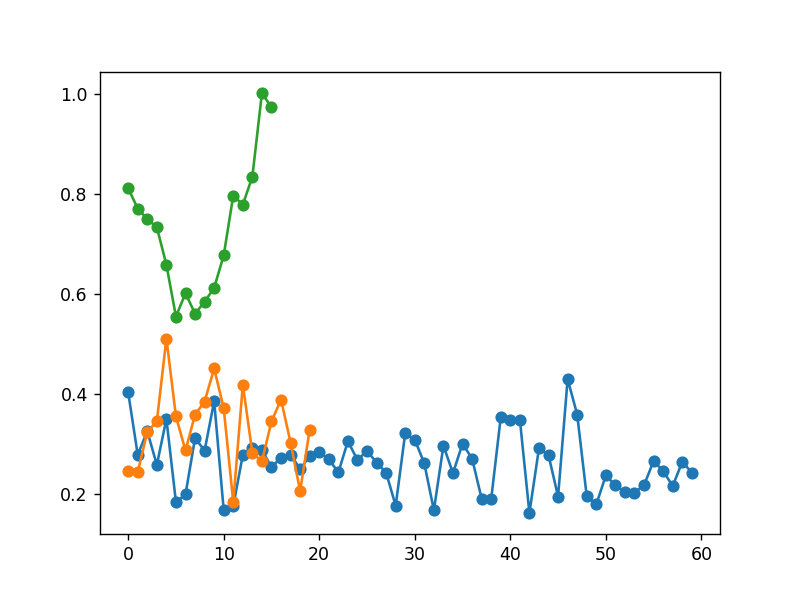

In [27]:
plt.figure()
plt.plot(sctr,'-o')
plt.plot(scs,'-o')
plt.plot(sct,'-o')

In [30]:
def get_model(reg,dimi):
        model = Sequential()
        model.add(Dense(8,input_dim=dimi,use_bias=True,kernel_regularizer=regularizers.l2(reg)))
        model.add(layers.LeakyReLU(alpha=0.01))
        #model.add(layers.BatchNormalization())
        #model.add(Dropout(0.1))
        model.add(Dense(6, use_bias=True,kernel_regularizer=regularizers.l2(reg)))
        model.add(layers.LeakyReLU(alpha=0.01))
        #model.add(Dropout(0.1))
        
        #model.add(layers.BatchNormalization())
        #model.add(Dropout(0.2))
        #model.add(layers.BatchNormalization())
        
        
        model.add(Dense(4,use_bias=True,kernel_regularizer=regularizers.l2(reg)))
        model.add(layers.LeakyReLU(alpha=0.01))
        #model.add(layers.BatchNormalization())
        #model.add(Dropout(0.1))
        
       
        opt = optimizers.Adam(learning_rate=0.001)
        #optN = optimizers.nadam(learning_rate=0.0005)\n",
        model.add(Dense(1,activation='linear'))
        model.compile(optimizer=opt,loss='mean_squared_error')
        return model

In [ ]:
model = load_model('models/Gij_1_0_S2.h5')

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40,restore_best_weights=True)
for i in range(0,3):
    for j in range(0,3):
        print(i,j)
        X_train, X_test, X_val, Y_train, Y_test, Y_val, Y_un = get_data(i,j)
        model = get_model(0,20)
        #model.fit(X_train,Y_train,eval_set=[(X_val,Y_val)],early_stopping_rounds=40,verbose=False)

        h=model.fit(X_train,Y_train,epochs=500,batch_size=512,validation_data=(X_val,Y_val),callbacks=[es],shuffle=False)
        #model.save('models/Gij_'+str(i)+'_'+str(j)+'_S2_test.h5')
        #pickle.dump(model, open("models/Gij_"+str(i)+"_"+str(j)+"_S1_XGB_test.dat", "wb"))

0 0
Train on 34560 samples, validate on 11520 samples
Epoch 1/500
34560/34560 [==============================] - 1s 35us/sample - loss: 0.9105 - val_loss: 0.6538
Epoch 2/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.7237 - val_loss: 0.5032
Epoch 3/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.5439 - val_loss: 0.3733
Epoch 4/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.3953 - val_loss: 0.2881
Epoch 5/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2913 - val_loss: 0.2311
Epoch 6/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2288 - val_loss: 0.1946
Epoch 7/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1900 - val_loss: 0.1644
Epoch 8/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1597 - val_loss: 0.1384
Epoch 9/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1344 -

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0139 - val_loss: 0.0147
Epoch 77/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0139 - val_loss: 0.0146
Epoch 78/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0138 - val_loss: 0.0146
Epoch 79/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0138 - val_loss: 0.0146
Epoch 80/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0137 - val_loss: 0.0145
Epoch 81/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0137 - val_loss: 0.0145
Epoch 82/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0136 - val_loss: 0.0144
Epoch 83/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0136 - val_loss: 0.0144
Epoch 84/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0135 - val_loss: 0.0143
Epoch 85/500
34560/34560 [===============

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0119 - val_loss: 0.0126
Epoch 152/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0119 - val_loss: 0.0126
Epoch 153/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0119 - val_loss: 0.0126
Epoch 154/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0119 - val_loss: 0.0126
Epoch 155/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0118 - val_loss: 0.0125
Epoch 156/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0118 - val_loss: 0.0125
Epoch 157/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0118 - val_loss: 0.0125
Epoch 158/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0118 - val_loss: 0.0125
Epoch 159/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0118 - val_loss: 0.0125
Epoch 160/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0104 - val_loss: 0.0113
Epoch 227/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0103 - val_loss: 0.0113
Epoch 228/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0103 - val_loss: 0.0113
Epoch 229/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0103 - val_loss: 0.0113
Epoch 230/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0103 - val_loss: 0.0113
Epoch 231/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0103 - val_loss: 0.0112
Epoch 232/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0103 - val_loss: 0.0112
Epoch 233/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0102 - val_loss: 0.0112
Epoch 234/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0102 - val_loss: 0.0112
Epoch 235/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0093 - val_loss: 0.0108
Epoch 302/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0093 - val_loss: 0.0108
Epoch 303/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0093 - val_loss: 0.0108
Epoch 304/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0093 - val_loss: 0.0108
Epoch 305/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0093 - val_loss: 0.0108
Epoch 306/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0093 - val_loss: 0.0108
Epoch 307/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0092 - val_loss: 0.0108
Epoch 308/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0092 - val_loss: 0.0108
Epoch 309/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0092 - val_loss: 0.0107
Epoch 310/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 377/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 378/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 379/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 380/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 381/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 382/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 383/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 384/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 385/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0100
Epoch 452/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0100
Epoch 453/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0100
Epoch 454/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0100
Epoch 455/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0099
Epoch 456/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0099
Epoch 457/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0099
Epoch 458/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0099
Epoch 459/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 460/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0044 - val_loss: 0.0045
Epoch 27/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0042 - val_loss: 0.0044
Epoch 28/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0041 - val_loss: 0.0042
Epoch 29/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0039 - val_loss: 0.0041
Epoch 30/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 31/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0036 - val_loss: 0.0038
Epoch 32/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0035 - val_loss: 0.0037
Epoch 33/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 34/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 35/500
34560/34560 [===============

Epoch 102/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 103/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 104/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 105/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0011 - val_loss: 0.0011
Epoch 106/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 107/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 108/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 109/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 110/500
34560/34560 [==============================] - 0s 3us/sample - loss: 9.9495e-04 - val_loss: 0.0010
Epoch 111/500
3

Epoch 173/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.5361e-04 - val_loss: 8.1810e-04
Epoch 174/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.5072e-04 - val_loss: 8.1505e-04
Epoch 175/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.4765e-04 - val_loss: 8.1348e-04
Epoch 176/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.4467e-04 - val_loss: 8.1136e-04
Epoch 177/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.4173e-04 - val_loss: 8.1036e-04
Epoch 178/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.3874e-04 - val_loss: 8.0918e-04
Epoch 179/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.3599e-04 - val_loss: 8.0677e-04
Epoch 180/500
34560/34560 [==============================] - 0s 3us/sample - loss: 6.3346e-04 - val_loss: 8.0516e-04
Epoch 181/500
34560/34560 [==============================] - 0s 

34560/34560 [==============================] - 0s 3us/sample - loss: 5.1697e-04 - val_loss: 7.5894e-04
Epoch 244/500
34560/34560 [==============================] - 0s 3us/sample - loss: 5.1565e-04 - val_loss: 7.5732e-04
Epoch 245/500
34560/34560 [==============================] - 0s 3us/sample - loss: 5.1387e-04 - val_loss: 7.5518e-04
Epoch 246/500
34560/34560 [==============================] - 0s 3us/sample - loss: 5.1260e-04 - val_loss: 7.5386e-04
Epoch 247/500
34560/34560 [==============================] - 0s 3us/sample - loss: 5.1116e-04 - val_loss: 7.5304e-04
Epoch 248/500
34560/34560 [==============================] - 0s 3us/sample - loss: 5.0974e-04 - val_loss: 7.5133e-04
Epoch 249/500
34560/34560 [==============================] - 0s 3us/sample - loss: 5.0837e-04 - val_loss: 7.5086e-04
Epoch 250/500
34560/34560 [==============================] - 0s 3us/sample - loss: 5.0716e-04 - val_loss: 7.4980e-04
Epoch 251/500
34560/34560 [==============================] - 0s 3us/sample - l

34560/34560 [==============================] - 0s 3us/sample - loss: 4.5158e-04 - val_loss: 7.2718e-04
Epoch 314/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.5097e-04 - val_loss: 7.2595e-04
Epoch 315/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.5038e-04 - val_loss: 7.2627e-04
Epoch 316/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.4974e-04 - val_loss: 7.2450e-04
Epoch 317/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.4910e-04 - val_loss: 7.2520e-04
Epoch 318/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.4866e-04 - val_loss: 7.2496e-04
Epoch 319/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.4805e-04 - val_loss: 7.2414e-04
Epoch 320/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.4741e-04 - val_loss: 7.2391e-04
Epoch 321/500
34560/34560 [==============================] - 0s 3us/sample - l

34560/34560 [==============================] - 0s 3us/sample - loss: 4.1077e-04 - val_loss: 6.7875e-04
Epoch 384/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.1014e-04 - val_loss: 6.7827e-04
Epoch 385/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.0965e-04 - val_loss: 6.7680e-04
Epoch 386/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.0906e-04 - val_loss: 6.7536e-04
Epoch 387/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.0840e-04 - val_loss: 6.7460e-04
Epoch 388/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.0787e-04 - val_loss: 6.7361e-04
Epoch 389/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.0732e-04 - val_loss: 6.7139e-04
Epoch 390/500
34560/34560 [==============================] - 0s 3us/sample - loss: 4.0666e-04 - val_loss: 6.6955e-04
Epoch 391/500
34560/34560 [==============================] - 0s 3us/sample - l

34560/34560 [==============================] - 0s 3us/sample - loss: 3.6974e-04 - val_loss: 5.7960e-04
Epoch 454/500
34560/34560 [==============================] - 0s 3us/sample - loss: 3.6955e-04 - val_loss: 5.7869e-04
Epoch 455/500
34560/34560 [==============================] - 0s 3us/sample - loss: 3.6913e-04 - val_loss: 5.7707e-04
Epoch 456/500
34560/34560 [==============================] - 0s 3us/sample - loss: 3.6871e-04 - val_loss: 5.7717e-04
Epoch 457/500
34560/34560 [==============================] - 0s 3us/sample - loss: 3.6851e-04 - val_loss: 5.7669e-04
Epoch 458/500
34560/34560 [==============================] - 0s 3us/sample - loss: 3.6794e-04 - val_loss: 5.7531e-04
Epoch 459/500
34560/34560 [==============================] - 0s 3us/sample - loss: 3.6754e-04 - val_loss: 5.7274e-04
Epoch 460/500
34560/34560 [==============================] - 0s 3us/sample - loss: 3.6699e-04 - val_loss: 5.7183e-04
Epoch 461/500
34560/34560 [==============================] - 0s 3us/sample - l

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0805 - val_loss: 0.0914
Epoch 25/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0795 - val_loss: 0.0901
Epoch 26/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0786 - val_loss: 0.0889
Epoch 27/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0777 - val_loss: 0.0879
Epoch 28/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0769 - val_loss: 0.0869
Epoch 29/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0761 - val_loss: 0.0860
Epoch 30/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0755 - val_loss: 0.0852
Epoch 31/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0748 - val_loss: 0.0844
Epoch 32/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0742 - val_loss: 0.0837
Epoch 33/500
34560/34560 [===============

Epoch 100/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0540 - val_loss: 0.0636
Epoch 101/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0538 - val_loss: 0.0633
Epoch 102/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0535 - val_loss: 0.0631
Epoch 103/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0533 - val_loss: 0.0628
Epoch 104/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0530 - val_loss: 0.0627
Epoch 105/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0527 - val_loss: 0.0625
Epoch 106/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0524 - val_loss: 0.0623
Epoch 107/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0522 - val_loss: 0.0621
Epoch 108/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0519 - val_loss: 0.0619
Epoch 109/500
34560

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0422 - val_loss: 0.0535
Epoch 176/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0421 - val_loss: 0.0534
Epoch 177/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0420 - val_loss: 0.0533
Epoch 178/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0419 - val_loss: 0.0533
Epoch 179/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0419 - val_loss: 0.0532
Epoch 180/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0418 - val_loss: 0.0531
Epoch 181/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0417 - val_loss: 0.0530
Epoch 182/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0417 - val_loss: 0.0529
Epoch 183/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0416 - val_loss: 0.0528
Epoch 184/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0384 - val_loss: 0.0504
Epoch 251/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0383 - val_loss: 0.0503
Epoch 252/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0383 - val_loss: 0.0503
Epoch 253/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0382 - val_loss: 0.0503
Epoch 254/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0382 - val_loss: 0.0503
Epoch 255/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0382 - val_loss: 0.0502
Epoch 256/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0381 - val_loss: 0.0502
Epoch 257/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0381 - val_loss: 0.0502
Epoch 258/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0381 - val_loss: 0.0502
Epoch 259/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0360 - val_loss: 0.0485
Epoch 326/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0360 - val_loss: 0.0484
Epoch 327/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0359 - val_loss: 0.0484
Epoch 328/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0359 - val_loss: 0.0484
Epoch 329/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0359 - val_loss: 0.0483
Epoch 330/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0358 - val_loss: 0.0483
Epoch 331/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0358 - val_loss: 0.0482
Epoch 332/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0358 - val_loss: 0.0482
Epoch 333/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0358 - val_loss: 0.0482
Epoch 334/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0345 - val_loss: 0.0472
Epoch 401/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0471
Epoch 402/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0471
Epoch 403/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0471
Epoch 404/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0470
Epoch 405/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0471
Epoch 406/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0470
Epoch 407/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0471
Epoch 408/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0344 - val_loss: 0.0470
Epoch 409/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.2289 - val_loss: 0.1882
Epoch 30/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2190 - val_loss: 0.1795
Epoch 31/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2096 - val_loss: 0.1714
Epoch 32/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2003 - val_loss: 0.1636
Epoch 33/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1914 - val_loss: 0.1562
Epoch 34/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1831 - val_loss: 0.1492
Epoch 35/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1754 - val_loss: 0.1427
Epoch 36/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1682 - val_loss: 0.1364
Epoch 37/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1615 - val_loss: 0.1308
Epoch 38/500
34560/34560 [===============

Epoch 105/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0152 - val_loss: 0.0134
Epoch 106/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0149 - val_loss: 0.0133
Epoch 107/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0147 - val_loss: 0.0132
Epoch 108/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0144 - val_loss: 0.0131
Epoch 109/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0142 - val_loss: 0.0130
Epoch 110/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0140 - val_loss: 0.0129
Epoch 111/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0139 - val_loss: 0.0128
Epoch 112/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0137 - val_loss: 0.0127
Epoch 113/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0136 - val_loss: 0.0127
Epoch 114/500
34560

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0100 - val_loss: 0.0113
Epoch 181/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0099 - val_loss: 0.0112
Epoch 182/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0099 - val_loss: 0.0112
Epoch 183/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0099 - val_loss: 0.0112
Epoch 184/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0099 - val_loss: 0.0112
Epoch 185/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0099 - val_loss: 0.0112
Epoch 186/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0099 - val_loss: 0.0112
Epoch 187/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0098 - val_loss: 0.0112
Epoch 188/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0098 - val_loss: 0.0112
Epoch 189/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0106
Epoch 256/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0106
Epoch 257/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0106
Epoch 258/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0106
Epoch 259/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0105
Epoch 260/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0105
Epoch 261/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0105
Epoch 262/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0105
Epoch 263/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0091 - val_loss: 0.0105
Epoch 264/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 331/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 332/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 333/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 334/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0103
Epoch 335/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0102
Epoch 336/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0102
Epoch 337/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0102
Epoch 338/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0087 - val_loss: 0.0102
Epoch 339/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0085 - val_loss: 0.0100
Epoch 406/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0085 - val_loss: 0.0100
Epoch 407/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0085 - val_loss: 0.0100
Epoch 408/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0085 - val_loss: 0.0100
Epoch 409/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0085 - val_loss: 0.0100
Epoch 410/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0085 - val_loss: 0.0100
Epoch 411/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0085 - val_loss: 0.0100
Epoch 412/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0100
Epoch 413/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0084 - val_loss: 0.0100
Epoch 414/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 481/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 482/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 483/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 484/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 485/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 486/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 487/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 488/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0083 - val_loss: 0.0099
Epoch 489/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0447 - val_loss: 0.0456
Epoch 56/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0445 - val_loss: 0.0453
Epoch 57/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0442 - val_loss: 0.0450
Epoch 58/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0439 - val_loss: 0.0448
Epoch 59/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0437 - val_loss: 0.0446
Epoch 60/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0434 - val_loss: 0.0443
Epoch 61/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0431 - val_loss: 0.0441
Epoch 62/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0429 - val_loss: 0.0438
Epoch 63/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0427 - val_loss: 0.0436
Epoch 64/500
34560/34560 [===============

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0342 - val_loss: 0.0357
Epoch 131/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0341 - val_loss: 0.0356
Epoch 132/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0341 - val_loss: 0.0356
Epoch 133/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0340 - val_loss: 0.0355
Epoch 134/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0340 - val_loss: 0.0355
Epoch 135/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0339 - val_loss: 0.0354
Epoch 136/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0338 - val_loss: 0.0354
Epoch 137/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0338 - val_loss: 0.0354
Epoch 138/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0337 - val_loss: 0.0353
Epoch 139/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0308 - val_loss: 0.0327
Epoch 206/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0308 - val_loss: 0.0328
Epoch 207/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0308 - val_loss: 0.0327
Epoch 208/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0307 - val_loss: 0.0327
Epoch 209/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0307 - val_loss: 0.0326
Epoch 210/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0307 - val_loss: 0.0326
Epoch 211/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0326
Epoch 212/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0325
Epoch 213/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0325
Epoch 214/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0306
Epoch 281/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0306
Epoch 282/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0306
Epoch 283/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0306
Epoch 284/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0305
Epoch 285/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0305
Epoch 286/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0305
Epoch 287/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0288 - val_loss: 0.0305
Epoch 288/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0288 - val_loss: 0.0305
Epoch 289/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0279 - val_loss: 0.0295
Epoch 356/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0279 - val_loss: 0.0295
Epoch 357/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0279 - val_loss: 0.0295
Epoch 358/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0279 - val_loss: 0.0295
Epoch 359/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0278 - val_loss: 0.0295
Epoch 360/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0278 - val_loss: 0.0295
Epoch 361/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0278 - val_loss: 0.0295
Epoch 362/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0278 - val_loss: 0.0295
Epoch 363/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0278 - val_loss: 0.0295
Epoch 364/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0291
Epoch 431/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 432/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 433/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 434/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 435/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 436/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 437/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 438/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0271 - val_loss: 0.0290
Epoch 439/500
34560/34560 [======

Epoch 5/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.5945 - val_loss: 0.5474
Epoch 6/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.4607 - val_loss: 0.4135
Epoch 7/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.3812 - val_loss: 0.3477
Epoch 8/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.3359 - val_loss: 0.3124
Epoch 9/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.3079 - val_loss: 0.2897
Epoch 10/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2895 - val_loss: 0.2748
Epoch 11/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2771 - val_loss: 0.2646
Epoch 12/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2679 - val_loss: 0.2572
Epoch 13/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2609 - val_loss: 0.2515
Epoch 14/500
34560/34560 [=======

Epoch 81/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1779 - val_loss: 0.1901
Epoch 82/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1774 - val_loss: 0.1899
Epoch 83/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1769 - val_loss: 0.1897
Epoch 84/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1764 - val_loss: 0.1894
Epoch 85/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1760 - val_loss: 0.1891
Epoch 86/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1755 - val_loss: 0.1889
Epoch 87/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1751 - val_loss: 0.1885
Epoch 88/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1746 - val_loss: 0.1882
Epoch 89/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1741 - val_loss: 0.1878
Epoch 90/500
34560/34560 [==

34560/34560 [==============================] - 0s 3us/sample - loss: 0.1455 - val_loss: 0.1733
Epoch 157/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1450 - val_loss: 0.1729
Epoch 158/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1444 - val_loss: 0.1724
Epoch 159/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1439 - val_loss: 0.1720
Epoch 160/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1433 - val_loss: 0.1715
Epoch 161/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1428 - val_loss: 0.1711
Epoch 162/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1423 - val_loss: 0.1708
Epoch 163/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1419 - val_loss: 0.1704
Epoch 164/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1414 - val_loss: 0.1702
Epoch 165/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.1291 - val_loss: 0.1670
Epoch 232/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1290 - val_loss: 0.1670
Epoch 233/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1289 - val_loss: 0.1668
Epoch 234/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1288 - val_loss: 0.1666
Epoch 235/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1287 - val_loss: 0.1666
Epoch 236/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1286 - val_loss: 0.1665
Epoch 237/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1285 - val_loss: 0.1664
Epoch 238/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1284 - val_loss: 0.1664
Epoch 239/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1283 - val_loss: 0.1663
Epoch 240/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.1222 - val_loss: 0.1588
Epoch 307/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1221 - val_loss: 0.1587
Epoch 308/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1221 - val_loss: 0.1587
Epoch 309/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1220 - val_loss: 0.1586
Epoch 310/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1219 - val_loss: 0.1585
Epoch 311/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1218 - val_loss: 0.1584
Epoch 312/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1218 - val_loss: 0.1584
Epoch 313/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1217 - val_loss: 0.1583
Epoch 314/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1216 - val_loss: 0.1583
Epoch 315/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.1167 - val_loss: 0.1529
Epoch 382/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1167 - val_loss: 0.1529
Epoch 383/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1166 - val_loss: 0.1527
Epoch 384/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1166 - val_loss: 0.1527
Epoch 385/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1165 - val_loss: 0.1526
Epoch 386/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1165 - val_loss: 0.1525
Epoch 387/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1164 - val_loss: 0.1525
Epoch 388/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1164 - val_loss: 0.1523
Epoch 389/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1164 - val_loss: 0.1523
Epoch 390/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.1141 - val_loss: 0.1506
Epoch 457/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1141 - val_loss: 0.1506
Epoch 458/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1141 - val_loss: 0.1506
Epoch 459/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1140 - val_loss: 0.1506
Epoch 460/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1140 - val_loss: 0.1505
Epoch 461/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1140 - val_loss: 0.1505
Epoch 462/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1139 - val_loss: 0.1505
Epoch 463/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1139 - val_loss: 0.1505
Epoch 464/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.1139 - val_loss: 0.1504
Epoch 465/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0591 - val_loss: 0.0683
Epoch 32/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0583 - val_loss: 0.0676
Epoch 33/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0574 - val_loss: 0.0668
Epoch 34/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0565 - val_loss: 0.0661
Epoch 35/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0557 - val_loss: 0.0655
Epoch 36/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0548 - val_loss: 0.0649
Epoch 37/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0540 - val_loss: 0.0644
Epoch 38/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0532 - val_loss: 0.0639
Epoch 39/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0525 - val_loss: 0.0635
Epoch 40/500
34560/34560 [===============

Epoch 107/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0359 - val_loss: 0.0470
Epoch 108/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0358 - val_loss: 0.0469
Epoch 109/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0357 - val_loss: 0.0467
Epoch 110/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0357 - val_loss: 0.0466
Epoch 111/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0356 - val_loss: 0.0465
Epoch 112/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0355 - val_loss: 0.0464
Epoch 113/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0354 - val_loss: 0.0463
Epoch 114/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0353 - val_loss: 0.0462
Epoch 115/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0353 - val_loss: 0.0461
Epoch 116/500
34560

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0321 - val_loss: 0.0416
Epoch 183/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0321 - val_loss: 0.0416
Epoch 184/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0321 - val_loss: 0.0415
Epoch 185/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0320 - val_loss: 0.0414
Epoch 186/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0320 - val_loss: 0.0414
Epoch 187/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0320 - val_loss: 0.0413
Epoch 188/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0319 - val_loss: 0.0413
Epoch 189/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0319 - val_loss: 0.0412
Epoch 190/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0319 - val_loss: 0.0412
Epoch 191/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0399
Epoch 258/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0399
Epoch 259/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0399
Epoch 260/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0399
Epoch 261/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0305 - val_loss: 0.0398
Epoch 262/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0305 - val_loss: 0.0398
Epoch 263/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0305 - val_loss: 0.0398
Epoch 264/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0305 - val_loss: 0.0398
Epoch 265/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0305 - val_loss: 0.0398
Epoch 266/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0298 - val_loss: 0.0384
Epoch 333/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0384
Epoch 334/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0384
Epoch 335/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0383
Epoch 336/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0383
Epoch 337/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0383
Epoch 338/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0383
Epoch 339/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0383
Epoch 340/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0297 - val_loss: 0.0382
Epoch 341/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0371
Epoch 408/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0371
Epoch 409/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0371
Epoch 410/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0371
Epoch 411/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0371
Epoch 412/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0371
Epoch 413/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0371
Epoch 414/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0370
Epoch 415/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0290 - val_loss: 0.0370
Epoch 416/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0364
Epoch 483/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0364
Epoch 484/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0364
Epoch 485/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0364
Epoch 486/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0364
Epoch 487/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0363
Epoch 488/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0363
Epoch 489/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0363
Epoch 490/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0286 - val_loss: 0.0363
Epoch 491/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0309 - val_loss: 0.0316
Epoch 58/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0306 - val_loss: 0.0314
Epoch 59/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0303 - val_loss: 0.0313
Epoch 60/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0301 - val_loss: 0.0311
Epoch 61/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0298 - val_loss: 0.0309
Epoch 62/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0296 - val_loss: 0.0307
Epoch 63/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0293 - val_loss: 0.0305
Epoch 64/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0291 - val_loss: 0.0303
Epoch 65/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0289 - val_loss: 0.0301
Epoch 66/500
34560/34560 [===============

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0212 - val_loss: 0.0235
Epoch 133/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0211 - val_loss: 0.0235
Epoch 134/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0211 - val_loss: 0.0235
Epoch 135/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0210 - val_loss: 0.0234
Epoch 136/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0210 - val_loss: 0.0234
Epoch 137/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0209 - val_loss: 0.0234
Epoch 138/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0208 - val_loss: 0.0233
Epoch 139/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0208 - val_loss: 0.0232
Epoch 140/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0207 - val_loss: 0.0232
Epoch 141/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0185 - val_loss: 0.0211
Epoch 208/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0184 - val_loss: 0.0211
Epoch 209/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0184 - val_loss: 0.0210
Epoch 210/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0184 - val_loss: 0.0210
Epoch 211/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0184 - val_loss: 0.0210
Epoch 212/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0183 - val_loss: 0.0210
Epoch 213/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0183 - val_loss: 0.0210
Epoch 214/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0183 - val_loss: 0.0209
Epoch 215/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0183 - val_loss: 0.0209
Epoch 216/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0172 - val_loss: 0.0197
Epoch 283/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0172 - val_loss: 0.0197
Epoch 284/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0172 - val_loss: 0.0197
Epoch 285/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0197
Epoch 286/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0197
Epoch 287/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0197
Epoch 288/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0197
Epoch 289/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0196
Epoch 290/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0171 - val_loss: 0.0196
Epoch 291/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0164 - val_loss: 0.0185
Epoch 358/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0164 - val_loss: 0.0185
Epoch 359/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0164 - val_loss: 0.0185
Epoch 360/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0163 - val_loss: 0.0185
Epoch 361/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0163 - val_loss: 0.0184
Epoch 362/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0163 - val_loss: 0.0184
Epoch 363/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0163 - val_loss: 0.0184
Epoch 364/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0163 - val_loss: 0.0184
Epoch 365/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0163 - val_loss: 0.0184
Epoch 366/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0158 - val_loss: 0.0178
Epoch 433/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0158 - val_loss: 0.0178
Epoch 434/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0158 - val_loss: 0.0178
Epoch 435/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0157 - val_loss: 0.0178
Epoch 436/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0157 - val_loss: 0.0178
Epoch 437/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0157 - val_loss: 0.0177
Epoch 438/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0157 - val_loss: 0.0177
Epoch 439/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0157 - val_loss: 0.0177
Epoch 440/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0157 - val_loss: 0.0177
Epoch 441/500
34560/34560 [======

Epoch 7/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.6456 - val_loss: 0.5836
Epoch 8/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.5737 - val_loss: 0.5115
Epoch 9/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.5015 - val_loss: 0.4472
Epoch 10/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.4349 - val_loss: 0.3948
Epoch 11/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.3772 - val_loss: 0.3538
Epoch 12/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.3314 - val_loss: 0.3210
Epoch 13/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2937 - val_loss: 0.2941
Epoch 14/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2636 - val_loss: 0.2730
Epoch 15/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.2438 - val_loss: 0.2597
Epoch 16/500
34560/34560 [=====

Epoch 83/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0787 - val_loss: 0.0932
Epoch 84/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0784 - val_loss: 0.0932
Epoch 85/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0782 - val_loss: 0.0930
Epoch 86/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0780 - val_loss: 0.0926
Epoch 87/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0777 - val_loss: 0.0924
Epoch 88/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0775 - val_loss: 0.0922
Epoch 89/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0773 - val_loss: 0.0919
Epoch 90/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0771 - val_loss: 0.0917
Epoch 91/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0770 - val_loss: 0.0914
Epoch 92/500
34560/34560 [==

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0705 - val_loss: 0.0831
Epoch 159/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0704 - val_loss: 0.0829
Epoch 160/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0703 - val_loss: 0.0829
Epoch 161/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0702 - val_loss: 0.0827
Epoch 162/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0702 - val_loss: 0.0827
Epoch 163/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0701 - val_loss: 0.0826
Epoch 164/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0700 - val_loss: 0.0825
Epoch 165/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0700 - val_loss: 0.0825
Epoch 166/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0699 - val_loss: 0.0823
Epoch 167/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0662 - val_loss: 0.0798
Epoch 234/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0662 - val_loss: 0.0798
Epoch 235/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0661 - val_loss: 0.0796
Epoch 236/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0661 - val_loss: 0.0796
Epoch 237/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0661 - val_loss: 0.0797
Epoch 238/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0661 - val_loss: 0.0797
Epoch 239/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0660 - val_loss: 0.0797
Epoch 240/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0659 - val_loss: 0.0796
Epoch 241/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0658 - val_loss: 0.0795
Epoch 242/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0633 - val_loss: 0.0776
Epoch 309/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0633 - val_loss: 0.0775
Epoch 310/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0633 - val_loss: 0.0775
Epoch 311/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0632 - val_loss: 0.0775
Epoch 312/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0632 - val_loss: 0.0775
Epoch 313/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0632 - val_loss: 0.0775
Epoch 314/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0632 - val_loss: 0.0775
Epoch 315/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0632 - val_loss: 0.0775
Epoch 316/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0632 - val_loss: 0.0774
Epoch 317/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0620 - val_loss: 0.0767
Epoch 384/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0620 - val_loss: 0.0766
Epoch 385/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0620 - val_loss: 0.0767
Epoch 386/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0619 - val_loss: 0.0768
Epoch 387/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0619 - val_loss: 0.0768
Epoch 388/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0619 - val_loss: 0.0767
Epoch 389/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0619 - val_loss: 0.0766
Epoch 390/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0619 - val_loss: 0.0767
Epoch 391/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0619 - val_loss: 0.0767
Epoch 392/500
34560/34560 [======

34560/34560 [==============================] - 0s 3us/sample - loss: 0.0611 - val_loss: 0.0758
Epoch 459/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0611 - val_loss: 0.0757
Epoch 460/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0611 - val_loss: 0.0757
Epoch 461/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0611 - val_loss: 0.0757
Epoch 462/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0611 - val_loss: 0.0757
Epoch 463/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0611 - val_loss: 0.0757
Epoch 464/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0610 - val_loss: 0.0757
Epoch 465/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0610 - val_loss: 0.0757
Epoch 466/500
34560/34560 [==============================] - 0s 3us/sample - loss: 0.0610 - val_loss: 0.0756
Epoch 467/500
34560/34560 [======

In [136]:
reg = [0,5e-4,1e-3,5e-3]
reg=[0]
scs = np.zeros((int(X_val.shape[0]/576),len(reg)))
sctr = np.zeros((int(X_train.shape[0]/576),len(reg)))
sct = np.zeros((int(X_test.shape[0]/576),len(reg)))
scv2 = np.zeros((int(X_val2.shape[0]/576),len(reg)))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40,restore_best_weights=True)

models=[]
for i, j in enumerate(reg):
    print(i)
    model = get_model(j,20)
    models.append(model)
    h=model.fit(X_train,Y_train,epochs=100,batch_size=512,validation_data=(X_val,Y_val),callbacks=[es],shuffle=True)
    
    scs[:,i] = get_score(model, X_val, Y_val, Y_un, 'std')
    sct[:,i] = get_score(model, X_test, Y_test, Y_un, 'std')
    sctr[:,i] = get_score(model, X_train, Y_train, Y_un, 'std')
    scv2[:,i] = get_score(model, X_val2, Y_val2, Y_un, 'std')
    
    #if(np.mean(sct,axis=0)[i]<0.13):
    #    model.save('models/Gij_0_1_S2.h5')
    

0
Train on 34560 samples, validate on 11520 samples
Epoch 1/100
34560/34560 [==============================] - 0s 13us/step - loss: 0.1757 - val_loss: 0.0185
Epoch 2/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0130 - val_loss: 0.0133
Epoch 3/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0113 - val_loss: 0.0112
Epoch 4/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0088 - val_loss: 0.0098
Epoch 5/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0081 - val_loss: 0.0109
Epoch 6/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0082 - val_loss: 0.0073
Epoch 7/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0067 - val_loss: 0.0095
Epoch 8/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0063 - val_loss: 0.0074
Epoch 9/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0049 - val_loss: 0.0066
Ep

Epoch 78/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 79/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0010 - val_loss: 0.0021
Epoch 80/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0013 - val_loss: 0.0024
Epoch 81/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 82/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 83/100
34560/34560 [==============================] - 0s 7us/step - loss: 0.0030 - val_loss: 0.0044
Epoch 84/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 85/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 86/100
34560/34560 [==============================] - 0s 8us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 87/100
34560/34560 [====================

<IPython.core.display.Javascript object>


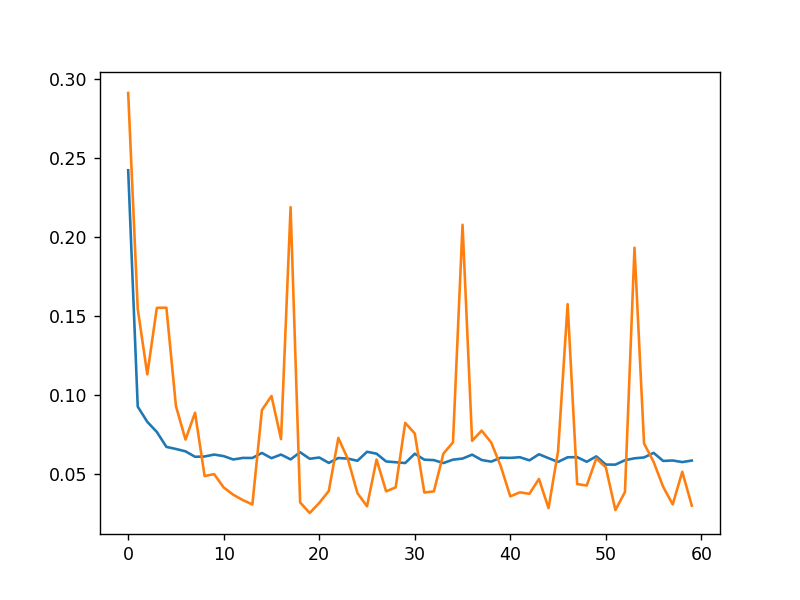

In [122]:
plt.figure()
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])


In [54]:
#pred = model.predict(X_test)
#pred = do_inverse_scaling(pred,Y_un,'std')
sct = get_score(model, X_test, Y_test, Y_un, 'std')
sctr = get_score(model, X_train, Y_train, Y_un, 'std')
scv = get_score(model, X_val, Y_val, Y_un, 'std')
scv2 = get_score(model, X_val2, Y_val2, Y_un, 'std')



In [ ]:
model = get_model(0.0,20)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40,restore_best_weights=True)
h = model.fit(X_train,Y_train,epochs=300,batch_size=512,validation_data=(X_val,Y_val),callbacks=[es],shuffle=False)


In [ ]:
reg = [50,100,150,200,250,350]
scs = np.zeros((int(X_val.shape[0]/576),len(reg)))
sctr = np.zeros((int(X_train.shape[0]/576),len(reg)))
sct = np.zeros((int(X_test.shape[0]/576),len(reg)))
for i, j in enumerate(reg):
    print(i)
    model = get_model_XGB(j)
    model.fit(X_train,Y_train,eval_set=[(X_val,Y_val)],early_stopping_rounds=40,verbose=False)
    
    scs[:,i] = get_score(model, X_val, Y_val, Y_un, 'std')
    sct[:,i] = get_score(model, X_test, Y_test, Y_un, 'std')
    sctr[:,i] = get_score(model, X_train, Y_train, Y_un, 'std')
    #if(np.mean(sct,axis=0)[i]<0.13):
    #    model.save('models/Gij_0_1_S2.h5')
    

In [ ]:
pickle.dump(model, open("models/Gij_2_0_S1_XGB.dat", "wb"))

In [24]:
def get_score(model, X, Y, Y_un, which):
    #pred = model.predict(X,ntree_limit=model.best_ntree_limit)
    pred = model.predict(X)
    pred = do_inverse_scaling(pred,Y_un,which)
    Y    = do_inverse_scaling(Y,Y_un,which)
    npts=576
    sc = np.zeros(int(Y.shape[0]/npts))
    for i in range(0,sc.shape[0]):
        sc[i]=np.sqrt(mean_squared_error(Y[i*npts:(i+1)*npts],pred[i*npts:(i+1)*npts])/np.mean(Y[i*npts:(i+1)*npts]**2))
        #sc[i]=r2_score(Y[i*576:(i+1)*576],pred[i*576:(i+1)*576])
    return sc

In [ ]:
def get_score2(model, X, Y, Y_un, which):
    pred = model.predict(X)
    pred = do_inverse_scaling(pred,Y_un,which)
    Y    = do_inverse_scaling(Y,Y_un,which)
    npts=576
    err = np.abs((pred-Y)/Y)
    sc = np.zeros(int(Y.shape[0]/npts))
    for i in range(0,sc.shape[0]):
        #sc[i]=np.sqrt(mean_squared_error(Y[i*npts:(i+1)*npts],pred[i*npts:(i+1)*npts])/np.mean(Y[i*npts:(i+1)*npts]**2))
        #sc[i]=r2_score(Y[i*576:(i+1)*576],pred[i*576:(i+1)*576])
        sc[i]=np.quantile(err[i*576+80:(i+1)*576-80],q=[0.9])
    return sc

In [ ]:
pred = model.predict(X_test)
pred = do_inverse_scaling(pred,Y_un,'median')
sct = np.zeros(int(X_test.shape[0]/576))
scs = np.zeros(int(X_val.shape[0]/576))
sctr = np.zeros(int(X_train.shape[0]/576))

Y_test = do_inverse_scaling(Y_test,Y_un,'median')
for i in range(0,sct.shape[0]):
    
    #sct[i]=r2_score(Y_test[i*576:(i+1)*576],pred[i*576:(i+1)*576])
    sct[i]=np.sqrt(mean_squared_error(Y_test[i*576:(i+1)*576],pred[i*576:(i+1)*576])/np.mean(Y_test[i*576:(i+1)*576]**2))
    
    
pred = model.predict(X_train)
pred = do_inverse_scaling(pred,Y_un,'median')
Y_train = do_inverse_scaling(Y_train,Y_un,'median')

for i in range(0,sctr.shape[0]):
    #sctr[i]=r2_score(Y_train[i*576:(i+1)*576],pred[i*576:(i+1)*576])
    sctr[i] = np.sqrt(mean_squared_error(Y_train[i*576:(i+1)*576],pred[i*576:(i+1)*576])/np.mean(Y_train[i*576:(i+1)*576]**2))

    
pred = model.predict(X_val)
pred = do_inverse_scaling(pred,Y_un,'median')
Y_val = do_inverse_scaling(Y_val,Y_un,'median')


for i in range(0,scs.shape[0]):
    #scs[i]=r2_score(Y_val[i*576:(i+1)*576],pred[i*576:(i+1)*576])    
    scs[i] = np.sqrt(mean_squared_error(Y_val[i*576:(i+1)*576],pred[i*576:(i+1)*576])/np.mean(Y_val[i*576:(i+1)*576]**2))


In [ ]:
def get_scores(model):
    pred = model.predict(X_test)
    sct = np.zeros(idxT.shape[0]-1)
    scs = np.zeros(idxV.shape[0]-1)
    sctr = np.zeros(idxTr.shape[0]-1)

    for i in range(0,sct.shape[0]):
        sct[i]=r2_score(Y_test[idxT[i]:idxT[i+1]],pred[idxT[i]:idxT[i+1]])
        #sct[i]=np.sqrt(mean_squared_error(Y_test[idxT[i]:idxT[i+1]],pred[idxT[i]:idxT[i+1]])/np.mean(Y_test[idxT[i]:idxT[i+1]]**2))

    pred = model.predict(X_train)
    for i in range(0,sctr.shape[0]):
        sctr[i]=r2_score(Y_train[idxTr[i]:idxTr[i+1]],pred[idxTr[i]:idxTr[i+1]])
        #sctr[i]=np.sqrt(mean_squared_error(Y_train[idxTr[i]:idxTr[i+1]],pred[idxTr[i]:idxTr[i+1]])/np.mean(Y_train[idxTr[i]:idxTr[i+1]]**2))
        
    pred = model.predict(X_val)
    for i in range(0,scs.shape[0]):
        scs[i]=r2_score(Y_val[idxV[i]:idxV[i+1]],pred[idxV[i]:idxV[i+1]])
        #scs[i]=np.sqrt(mean_squared_error(Yval[idxV[i]:idxV[i+1]],pred[idxV[i]:idxV[i+1]])/np.mean(Yval[idxV[i]:idxV[i+1]]**2))
    return sctr, sct, scs, pred


In [ ]:
model = load_model('ACCU_0_0_S1.h5')
nfs = 16
i1=0
j1=0
X_train, Y_train,_ = get_CNN_training('./data/CaseC_smooth/',0,60,60,nfs,i1,j1)
X_test, Y_test,_ = get_CNN_training('./data/CaseC_smooth/',60,24,60,nfs,i1,j1)
Xval, Yval, _ = get_CNN_training('./data/CaseC_smooth/',84,36,60,nfs,i1,j1)
X_train, X_test, Xval, Y_train, Y_test, Yval = scale_data(X_train, X_test,  Xval, Y_train, Y_test,  Yval,'std')


#X_train = np.reshape(X_train,(X_train.shape[0]*X_train.shape[1],nfs))
#X_test = np.reshape(X_test,(X_test.shape[0]*X_test.shape[1],nfs))
#Xval = np.reshape(Xval,(Xval.shape[0]*Xval.shape[1],nfs))
#Y_train = np.reshape(Y_train,(Y_train.shape[0]*Y_train.shape[1]))
#Y_test = np.reshape(Y_test,(Y_test.shape[0]*Y_test.shape[1]))
#Yval = np.reshape(Yval,(Yval.shape[0]*Yval.shape[1]))
Xval[:,15]=1
a1u1 = model.predict(Xval)

X_train, Y_train,_ = get_CNN_training('./data/CaseC_smooth/',0,60,60,nfs,i1,j1)
Xval, Yval,_ = get_CNN_training('./data/CaseC_smooth/',84,36,60,nfs,i1,j1)

a1u1 = a1u1*np.mean(Y_train)




In [ ]:
def get_au():
    out = np.zeros((20736,3,3))
    nfs = 16
    
    for i in range(0,1):
        for j in range(0,2):
            print(i,j)
            model = load_model('ACCU_'+str(i)+'_'+str(j)+'_S1.h5')
            X_train, Y_train,_ = get_CNN_training('./data/CaseC_smooth/',0,60,60,nfs,i,j)
            X_test, Y_test,_ = get_CNN_training('./data/CaseC_smooth/',60,24,60,nfs,i,j)
            Xval, Yval,_ = get_CNN_training('./data/CaseC_smooth/',84,36,60,nfs,i,j)
            meanY = np.mean(Y_train)
            minY = np.min(Y_train)
            maxY = np.max(Y_train)
            
            X_train, _, Xval, Y_train, _, Yval = scale_data(X_train, X_test,  Xval, Y_train, Y_test,  Yval,'std')
            #X_train = np.reshape(X_train,(X_train.shape[0]*X_train.shape[1],nfs))
            #Xval = np.reshape(Xval,(Xval.shape[0]*Xval.shape[1],nfs))
            Xval[:,15]=1
            out[:,i,j] = np.squeeze(model.predict(Xval))
            out[:,i,j] = out[:,i,j]*meanY
            #out[:,i,j] = out[:,i,j]*(maxY-minY) + minY
    return out

In [ ]:
def get_G_L(direc,ist,nt, delU,nfs):
    
    Gij, _, _, _, _, _, Lij, _, _, _, _, _, _ = get_training_data_time(direc,ist,False,False,delU)
    G = np.zeros(((nt)*576,3,3))
    L = np.zeros(((nt)*576,3,3))
    
    G[0:576,:,:] = np.moveaxis(Gij[:,:,:],-1,0)
    L[0:576,:,:] = np.moveaxis(Lij[:,:,:],-1,0)
    
    for i in range(ist+1,ist+nt):
        Gij, _, _, _, _, _, Lij, _, _, _, _, _, _ = get_training_data_time(direc,i,False,False,delU)
        G[(i-ist)*576:(i-ist+1)*576,:,:] = np.moveaxis(Gij,-1,0)
        L[(i-ist)*576:(i-ist+1)*576,:,:] = np.moveaxis(Lij,-1,0)
    return G,L

In [ ]:
Gij, Lij = get_G_L('./data/CaseC_smooth/',84,36,60,16)

In [ ]:
scs = np.zeros((36,3,3))
for i in range(0,3):
    for j in range(0,3):
        for k in range(0,36):
            
            scs[k,i,j] = r2_score(outD[k*576:(k+1)*576,i,j],out[k*576:(k+1)*576,i,j])
            

In [ ]:
AIUJ = get_au()

In [ ]:
out = np.zeros((Gij.shape[0],3,3))
outD = np.zeros((Gij.shape[0],3,3))

for i in range(out.shape[0]):
    out[i,:,:] = np.matmul(AIUJ[i,:,:],Lij[i,:,:])
    outD[i,:,:] = np.matmul(Gij[i,:,:],Lij[i,:,:])
    

In [ ]:
plt.figure()
plt.plot(Lij[0:576,0,0])

In [ ]:
r2_score(Gij[:,0,1],AIUJ[:,0,1])

In [ ]:
plt.figure()
#plt.plot(Gij[0:576,0,0]*Lij[0:576,0,0]+Gij[0:576,0,1]*Lij[0:576,1,0]+Gij[0:576,0,2]*Lij[0:576,2,0])
#plt.plot(AIUJ[0:576,0,0]*Lij[0:576,0,0]+AIUJ[0:576,0,1]*Lij[0:576,1,0]+AIUJ[0:576,0,2]*Lij[0:576,2,0])

#plt.plot(Gij[0:576,0,0]*Lij[0:576,0,0]+Gij[0:576,0,1]*Lij[0:576,1,0])
#plt.plot(AIUJ[0:576,0,0]*Lij[0:576,0,0]+AIUJ[0:576,0,1]*Lij[0:576,1,0])

plt.plot(Gij[0:576,0,0]*Lij[0:576,0,0])
plt.plot(AIUJ[0:576,0,0]*Lij[0:576,0,0])



In [ ]:
Gij[]

In [ ]:
plt.figure()
plt.plot(Gij[136:439,0,0]*Lij[136:439,0,0])
plt.plot(AIUJ[136:439,0,0]*Lij[136:439,0,0])
#plt.plot(Gij[0:576,0,1]*Lij[0:576,1,0])
#plt.plot(AIUJ[0:576,0,1]*Lij[0:576,1,0])


In [ ]:
r2_score(Gij[0:576,0,0]*Lij[0:576,0,0]+Gij[0:576,0,1]*Lij[0:576,1,0],Gij[0:576,0,0]*Lij[0:576,0,0]+AIUJ[0:576,0,1]*Lij[0:576,1,0])

In [ ]:
s1 = Gij[0:576,0,1]*Lij[0:576,1,0] + Gij[0:576,0,0]*Lij[0:576,0,0] 
s2 = AIUJ[0:576,0,1]*Lij[0:576,1,0] + AIUJ[0:576,0,0]*Lij[0:576,0,0]

In [ ]:
r2_score(s1[200:350],s2[200:350])

In [ ]:
Lij[0:103,0,0]=0.0

In [ ]:
plt.figure()
plt.plot((Gij[0:576,0,0]*Lij[0:576,0,0]-AIUJ[0:576,0,0]*Lij[0:576,0,0])/(Gij[0:576,0,0]*Lij[0:576,0,0]))

In [ ]:
np.sqrt(mean_squared_error(s1,s2)/np.mean(s1**2))

In [ ]:
plt.figure()
plt.plot(outD[0:576,0,0])
plt.plot(out[0:576,0,0])


In [ ]:
X_train, Y_train = get_CNN_training('./data/CaseC/',0,60,60,nfs,i1,j1)


In [ ]:
plt.figure()
plt.plot((a1u1[0:576,0]*np.std(Y_train)+np.mean(Y_train))*Xval[0:576,0])
plt.plot((Yval[0:576]*np.std(Y_train)+np.mean(Y_train))*Xval[0:576,0])


In [ ]:
Xval, Yval = get_CNN_training('./data/CaseC/',84,36,60,nfs,0,0)
Xval = np.reshape(Xval,(Xval.shape[0]*Xval.shape[1],nfs))
Yval = np.reshape(Yval,(Yval.shape[0]*Yval.shape[1]))

T11 = np.copy(Xval[:,0])
T21 = np.copy(Xval[:,1])
T31 = np.copy(Xval[:,2])

In [ ]:
Xval, a1u12 = get_CNN_training('./data/CaseC/',84,36,60,nfs,0,0)
Xval, a1u22 = get_CNN_training('./data/CaseC/',84,36,60,nfs,0,1)
Xval, a1u32 = get_CNN_training('./data/CaseC/',84,36,60,nfs,0,2)
a1u12 = np.reshape(a1u12,(a1u12.shape[0]*a1u12.shape[1]))
a1u22 = np.reshape(a1u22,(a1u22.shape[0]*a1u22.shape[1]))
a1u32 = np.reshape(a1u32,(a1u32.shape[0]*a1u32.shape[1]))


In [ ]:
out = a1u1*T11[:,None] + a1u2*T21[:,None] + a1u3*T31[:,None]

In [ ]:
out2 = a1u32*T31 + a1u22*T21 + a1u12*T11

In [ ]:
nfs = 19
i1=1
j1=2
X, Y, _ = get_CNN_training('./data/50_new/',0,150,1,100,nfs,i1,j1)
#nT = [i for i in range(0,int(X.shape[0]/576))]
#np.random.shuffle(nT)

X_train = np.zeros((576*75,nfs))
Y_train = np.zeros((576*75,1))
X_test = np.zeros((576*45,nfs))
Y_test = np.zeros((576*45,1))
X_val = np.zeros((576*30,nfs))
Y_val = np.zeros((576*30,1))


for i in range(0,75):
    X_train[i*576:(i+1)*576,:] = X[nT[i]*576:(nT[i]+1)*576,:]
    Y_train[i*576:(i+1)*576,:] = Y[nT[i]*576:(nT[i]+1)*576,None]
j=0
for i in range(75,105):
    X_val[j*576:(j+1)*576,:] = X[nT[i]*576:(nT[i]+1)*576,:]
    Y_val[j*576:(j+1)*576,:] = Y[nT[i]*576:(nT[i]+1)*576,None]
    j=j+1
j=0
for i in range(105,150):
    X_test[j*576:(j+1)*576,:] = X[nT[i]*576:(nT[i]+1)*576,:]
    Y_test[j*576:(j+1)*576,:] = Y[nT[i]*576:(nT[i]+1)*576,None]
    j=j+1

X_train, X_test, X_val, Y_train, Y_test, Y_val = scale_data(X_train, X_test,  X_val, Y_train, Y_test,  Y_val,'std')


In [ ]:
accu = np.zeros((X_test.shape[0],3,3))

In [ ]:
model = load_model('models/ACCU_0_2_S2.h5')
accu[:,0,2] = model.predict(X_test)[:,0]

In [ ]:
def get_Gij():
    #nT = np.loadtxt('NT')
    #nT=nT.astype(int)
    nfs = 23
    DNS = np.zeros((576*16,3,3))
    PRED = np.zeros((576*16,3,3))
    for i1 in range(0,2):
        for j1 in range(0,3):
            print(i1,j1)
            #X, Y, _ = get_CNN_training('./data/CaseF_scaled/',0,80,2,100,nfs,i1,j1)
            #nfs=20
            #npts=576
            #X_train = np.zeros((npts*30,nfs))
            #Y_train = np.zeros((npts*30,1))

            #X_val = np.zeros((npts*10,nfs))
            #Y_val = np.zeros((npts*10,1))


            #for i in range(0,30):
            #    X_train[i*npts:(i+1)*npts,:] = X[nT[i]*npts:(nT[i]+1)*npts,:]
            #    Y_train[i*npts:(i+1)*npts,:] = Y[nT[i]*npts:(nT[i]+1)*npts,None]
            #j=0
            #for i in range(30,40):
            #    X_val[j*npts:(j+1)*npts,:] = X[nT[i]*npts:(nT[i]+1)*npts,:]
            #    Y_val[j*npts:(j+1)*npts,:] = Y[nT[i]*npts:(nT[i]+1)*npts,None]
            #j=j+1
            #nfs=23
            
            X_train, X_test, X_val, Y_train, Y_test, Y_val, Y_un = get_data(i1,j1)


            
            #X_test, Y_test, _ = get_CNN_training('./data/50_new_scaled/',0,80,5,150,nfs,i1,j1)
            #X_test, Y_test, _ = get_CNN_training('./data/CaseF/',80,20,2,150,nfs,i1,j1)

    
            #meanY = np.mean(Y_train)
            #stdY = np.std(Y_train)
            DNS[:,i1,j1] = Y_test[:,0]           

            #X_train, X_test, X_val, Y_train, Y_test, Y_val = scale_data(X_train, X_test,  X_val, Y_train, Y_test,  Y_val,'std')
            model = load_model('models/Gij_'+str(i1)+'_'+str(j1)+'_S2_test.h5')
            #model=pickle.load(open("models/Gij_"+str(i1)+"_"+str(j1)+"_S2_XGB.dat", "rb"))
            
            PRED[:,i1,j1] = model.predict(X_test)[:,0]
            PRED[:,i1,j1] = do_inverse_scaling(PRED[:,i1,j1],Y_un,'std')
            DNS[:,i1,j1] = do_inverse_scaling(DNS[:,i1,j1],Y_un,'std')
   
    return PRED, DNS

In [ ]:
PRED_S2_ANN, _ = get_Gij()

In [ ]:
    plt.figure(figsize=(14,10))
    k=8
    x = np.linspace(0,0.423e-2,576)
    x=x-0.423e-2/2
    x=x*100
    for i in range(0,3):
      for j in range(0,3):
        plt.subplot(3,3,i*3+j+1) 
        
        #plt.plot(x,(DNS[k*576:(k+1)*576,i,j]-min(DNS[k*576:(k+1)*576,i,j]))/(max((DNS[k*576:(k+1)*576,i,j]))-min(DNS[k*576:(k+1)*576,i,j])),'--x',linewidth=2,markevery=12,markeredgewidth=1,markersize=8)
        #plt.plot(x,(PRED[k*576:(k+1)*576,i,j]-min(DNS[k*576:(k+1)*576,i,j]))/(max((DNS[k*576:(k+1)*576,i,j]))-min(DNS[k*576:(k+1)*576,i,j])),linewidth=2)
        #plt.plot(x,(PRED_XGB[k*576:(k+1)*576,i,j]-min(DNS[k*576:(k+1)*576,i,j]))/(max((DNS[k*576:(k+1)*576,i,j]))-min(DNS[k*576:(k+1)*576,i,j])),linewidth=2)

        #plt.plot(MERRS[:,i,j]*100,linewidth=2)
        plt.plot(x,RSS_DNS[k*576:(k+1)*576,i,j]/max(abs(RSS_DNS[k*576:(k+1)*576,i,j])),'-x',linewidth=1,markevery=10,markeredgewidth=1,markersize=6)
        plt.plot(x,RSS_ANN[k*576:(k+1)*576,i,j]/max(abs(RSS_DNS[k*576:(k+1)*576,i,j])),linewidth=1.5)
        plt.plot(x,RSS_XGB[k*576:(k+1)*576,i,j]/max(abs(RSS_DNS[k*576:(k+1)*576,i,j])),linewidth=1.5)
        
        #plt.plot(x,(PRED[k*576:(k+1)*576,i,j]+PRED[k*576:(k+1)*576,j,i])/max(abs(RSS_DNS[k*576:(k+1)*576,i,j])),linewidth=1.5)
        
        #plt.plot(x,RSS_LIPM[k*576:(k+1)*576,i,j]/max(abs(RSS_DNS[k*576:(k+1)*576,i,j])),linewidth=1.5)
        #plt.plot(x,RSS_LSSG[k*576:(k+1)*576,i,j]/max(abs(RSS_DNS[k*576:(k+1)*576,i,j])),linewidth=1.5)
        #plt.plot(x,RSS_SLM[k*576:(k+1)*576,i,j]/max(abs(RSS_DNS[k*576:(k+1)*576,i,j])),linewidth=1.5)
        
        plt.locator_params(axis='y', nbins=3)
        plt.locator_params(axis='x', nbins=3)
        #plt.title(str(i+1)+','+str(j+1))
        
        #plt.gca().get_yaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        #plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        #plt.grid(alpha=0.5)
        if(i==0 and j==0):
            plt.legend(('DNS','ANN','XGB','LSSG','SLM'))
        #if(i==1 and j==1):
            #plt.ylim((\))
            #plt.yticks([-0.5, 0, 0.5])
        #plt.ylim((-0.1,1.1))
        plt.subplots_adjust(wspace=0.05)
        plt.subplots_adjust(hspace=0.05)
        plt.xlabel('$Y (cm)$')

        if(i<2):
        #plt.gca().axes.get_yaxis().set_visible(False)
            #plt.gca().axes.get_xaxis().set_visible(False)
            plt.xticks([-0.2,0.0,0.2],"")
            plt.xlabel("")
        if(j>0):
            #plt.gca().axes.get_yaxis().set_visible(False)
            plt.yticks([0,0.5,1],"")
        plt.grid(alpha=0.5)
        #x = np.linspace(min(Gij[i,j,:]*eps/K),max(Gij[i,j,:]*eps/K),10)        
        ax=plt.gca()
        plt.text(0.1,0.9,str(i+1)+','+str(j+1),transform=ax.transAxes,bbox=dict(facecolor='white',alpha=0.5),size=15)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
            ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(15)
        #plt.plot(x,x,'k--')
    #plt.savefig('Gij-ANN-XGB-S2.png',dpi=300,bbox_inches = "tight")     
    #plt.close()
            
            

In [ ]:
np.sqrt(mean_squared_error(DNS[i*576:(i+1)*576,1,2],PRED[i*576:(i+1)*576,1,2])/np.mean(DNS[i*576:(i+1)*576,1,2]**2))

In [ ]:
plt.figure()
i=10
plt.plot(DNS[i*576:(i+1)*576,1,2])
plt.plot(PRED[i*576:(i+1)*576,1,2])


In [ ]:
for i in range(0,45):
    MERRS[i,0,0] = np.mean(e3[i*576:(i+1)*576])

In [ ]:
mean_squared_error

In [ ]:
MERRS = np.zeros((45,3,3))
STDERRS = np.zeros((45,3,3))
for i in range(0,45):
    A=np.sqrt(np.sum((DNS[i*576:(i+1)*576,:,:]-PRED[i*576:(i+1)*576,:,:])**2,axis=(1,2)))/np.sqrt(np.sum((DNS[i*576:(i+1)*576,:,:])**2,axis=(1,2)))
    A = np.sort(A)
    MERRS[i,0,0] = np.mean(A[0:-5])

In [ ]:
MERRS2 = np.zeros((10,3,3))
STDERRS = np.zeros((10,3,3))
for i in range(0,10):
    for j in range(0,3):
        for k in range(0,3):
            
            MERRS2[i,j,k] = np.sqrt(mean_squared_error(DNS[i*576:(i+1)*576,j,k],PRED[i*576:(i+1)*576,j,k])/np.mean(DNS[i*576:(i+1)*576,j,k]**2))
            
                        

In [ ]:
ERRS_XGB_S1 = MERRS2

In [ ]:
plt.figure()
plt.plot(MERRS2[:,1,0])
#plt.plot(MERRS[:,2,2])


In [ ]:
plt.figure()
i=20
plt.plot(PRED[i*576:(i+1)*576,1,0])
plt.plot(DNS[i*576:(i+1)*576,1,0])


In [ ]:
EANNS2 = np.zeros(16)
EXGBS2 = np.zeros(16)

for  i in range(0,16):
    EANNS2[i] = np.mean(E_ANN_S2[i*576:(i+1)*576])
    EXGBS2[i] = np.mean(E_XGB_S2[i*576:(i+1)*576])
    

In [ ]:
np.random.seed(10)
np.random.shuffle(MERRS2)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(EANNS1[0:10],'-x',linewidth=4,markersize=10,markeredgewidth=2)
plt.plot(EXGBS1[0:10],'-x',linewidth=4,markersize=10,markeredgewidth=2)
plt.plot(EANNS2[0:10],'-o',linewidth=4,markersize=10,markeredgewidth=2)
plt.plot(EXGBS2[0:10],'-o',linewidth=4,markersize=10,markeredgewidth=2)

#plt.ylim(0,0.4)
plt.ylabel('$\epsilon_T$')
plt.xlabel('Sample')
plt.grid(alpha=0.2)
ax=plt.gca()
plt.yticks([0, 0.10,0.20])
#plt.legend(('$\epsilon_{3,1}$','$\epsilon_{3,2}$','$\epsilon_{3,3}$'),prop={'size': 18})
plt.legend(('$\epsilon$-ANN-$\mathcal{S}$1','$\epsilon$-XGB-$\mathcal{S}$1','$\epsilon$-ANN-$\mathcal{S}$2','$\epsilon$-XGB-$\mathcal{S}$2'),prop={'size': 16})

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
            ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.savefig('eps-S1.png',dpi=300,bbox_inches = "tight")     
    #plt.close()
#plt.plot(MERRS[:,2,2]*100,'-x')
#plt.plot(m*100,'-x')




In [ ]:
plt.figure()
i=13
j=0
k=0
#plt.plot(err[i*576:(i+1)*576,j,k]/DNS[i*576:(i+1)*576,j,k],'o')
plt.plot(DNS[i*576:(i+1)*576,j,k],'o')
plt.plot(PRED2[i*576:(i+1)*576,j,k])
plt.plot(PRED[i*576:(i+1)*576,j,k])



In [ ]:
def get_data_RSS(direc,ist,nt,stp, delU):
            _, Tij, meanVelGrad, b, Sij, _, Lij, eps, K, _, _, _, _ = get_training_data_time(direc,ist,False,False,delU)
            for i in range(ist+stp,ist+nt,stp):
                _, Tij1, meanVelGrad1, b1, Sij1, _, Lij1, eps1, K1, _, _, _, _ = get_training_data_time(direc,i,False,False,delU)
                Tij = np.append(Tij, Tij1, axis=2)
                b = np.append(b, b1, axis=2)                
                meanVelGrad = np.append(meanVelGrad,meanVelGrad1,axis=2)
                Sij = np.append(Sij,Sij1,axis=2)
                Lij = np.append(Lij,Lij1,axis=2)
                eps = np.append(eps,eps1,axis=0)
                K = np.append(K,K1,axis=0)
            
                
            return Tij, b, meanVelGrad, Sij, Lij, eps, K

In [ ]:
def get_RSM(Gij,Tij):
    RSM = np.zeros((Gij.shape[0],3,3))
    #Gij = np.reshape(Gij,(Gij.shape[0],3,3))
    #Tij = np.reshape(Tij,(Tij.shape[0],3,3))
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                RSM[:,i,j]=RSM[:,i,j]+Gij[:,i,k]*Tij[:,k,j]+Gij[:,j,k]*Tij[:,k,i]
    return RSM

In [ ]:
def LIPM_model(C0,CIPM,alpha2,alpha3,beta1,beta2,beta3,gama5,gama6,b,Tij,meanVelGrad,eps,K,lambdaij,Sij):
    pred = np.zeros((3,3,K.shape[0]))
    for i in range(0,K.shape[0]):        
        #P = - 0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) + np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))
        #To be used when normalised by eps/K 
        P1 = b[:,:,i]*Sij[:,:,i]
        P = -2.0*P1.sum()*K[i]
        B3 = np.matmul(np.matmul(b[:,:,i],b[:,:,i]),b[:,:,i])
        
        alpha1 = -(0.5+3.0/4*C0)+3.0*alpha2*np.trace(B3)+0.5*CIPM*P/eps[i] #P is non dim so no omega here
        
        pred[:,:,i] = (alpha1*np.eye(3,3)+alpha2*b[:,:,i] + alpha3*np.matmul(b[:,:,i],b[:,:,i]))*eps[i]/K[i] + beta1*np.eye(3,3)*np.trace(meanVelGrad[:,:,i]) + \
        beta2*meanVelGrad[:,:,i] + beta3*np.transpose(meanVelGrad[:,:,i]) + gama5*np.matmul(b[:,:,i],meanVelGrad[:,:,i]) + \
        gama6*np.matmul(b[:,:,i],np.transpose(meanVelGrad[:,:,i]))
     
        pred[:,:,i] = pred[:,:,i]+0.5*C0*eps[i]*lambdaij[:,:,i]
       
    return pred

    

In [ ]:
def LSSG_model(C0,C2SSG,C3SSG,C3SSGp,C3starSSG,C5SSG,b,Tij,meanVelGrad,eps,K,lambdaij,Sij):
    pred = np.zeros((3,3,K.shape[0]))
    # To be used when normalised with delta and delU
    for i in range(0,K.shape[0]):        
        P = - 0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) + np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))
        B3 = np.matmul(np.matmul(b[:,:,i],b[:,:,i]),b[:,:,i])
        alpha2 = 4.0-1.7*P/eps[i]
        alpha1 = -(0.5+3.0/4*C0)-1.0/4*C2SSG*np.trace(np.matmul(b[:,:,i],b[:,:,i])) + \
        (3.0*alpha2-3.0/4*C2SSG)*np.trace(B3) + 3.0/8*(C3SSG-C3starSSG*np.sqrt(np.trace(np.matmul(b[:,:,i],b[:,:,i]))))*P/eps[i] 
        alpha3 = 3.0/4*C2SSG-3.0*alpha2
        beta1 = -0.2
        beta2 = 3.0/8*(C3SSG-C3SSGp*np.sqrt(np.trace(np.matmul(b[:,:,i],b[:,:,i]))))+0.5
        beta3 = 3.0/8*(C3SSG-C3SSGp*np.sqrt(np.trace(np.matmul(b[:,:,i],b[:,:,i]))))-0.5
        gama5 = 3.0/2-3.0/4*C5SSG
        gama6 = -3.0/2+3.0/4*C5SSG
        
        pred[:,:,i] = (alpha1*np.eye(3,3)+alpha2*b[:,:,i] + alpha3*np.matmul(b[:,:,i],b[:,:,i]))*eps[i]/K[i] + beta1*np.eye(3,3)*np.trace(meanVelGrad[:,:,i]) + \
        beta2*meanVelGrad[:,:,i] + beta3*np.transpose(meanVelGrad[:,:,i]) + gama5*np.matmul(b[:,:,i],meanVelGrad[:,:,i]) + \
        gama6*np.matmul(b[:,:,i],np.transpose(meanVelGrad[:,:,i]))
        
        
        pred[:,:,i] = pred[:,:,i]+0.5*C0*eps[i]*lambdaij[:,:,i]
    return pred

    

In [ ]:
def get_SLM(C0,eps,K,Lij):
    pred = np.zeros((3,3,K.shape[0]))

    for i in range(0,K.shape[0]):
        pred[:,:,i] = -(0.5+3.0/4*C0)*np.eye(3,3)*eps[i]/K[i] + 0.5*C0*eps[i]*Lij[:,:,i]

    return pred

In [ ]:
Tij, b, meanVelGrad, Sij, Lij, eps, K = get_data_RSS('./data/50_new/',15,80,5,100)
LIPM  = LIPM_model(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,b,Tij,meanVelGrad,eps,K,Lij,Sij)
LSSG = LSSG_model(2.1,4.2,0.8,1.0,1.0,0.4,b,Tij,meanVelGrad,eps,K,Lij,Sij)

SLM = get_SLM(2.1,eps,K,Lij)
#LIPM  = np.zeros((576*45,3,3))
#LSSG  = np.zeros((576*45,3,3))
#SLM  = np.zeros((576*45,3,3))

#Tij = np.zeros((576*45,3,3))
#j=0
#for k in range(10,150):
LIPM = np.moveaxis(LIPM,2,0)
LSSG = np.moveaxis(LSSG,2,0)
SLM  = np.moveaxis(SLM,2,0)
Tij  = np.moveaxis(Tij,2,0)
#    j=j+1

RSS_LIPM = get_RSM(LIPM,Tij)
RSS_LSSG = get_RSM(LSSG,Tij)
RSS_DNS = get_RSM(DNS_S2,Tij)
RSS_XGB = get_RSM(PRED_S2_XGB,Tij)
RSS_ANN = get_RSM(PRED_S2_ANN,Tij)

RSS_SLM = get_RSM(SLM,Tij)
#LIPM = LIPM_model(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,b2,Tij2,meanVelGrad2,eps2,K2,Lij2,Sij2)
#LSSG = LSSG_model(2.1,4.2,0.8,1.0,1.0,0.4,b,Tij,meanVelGrad,eps,K,Lij,Sij)

In [ ]:
plt.figure()
i=1
#plt.plot(RSS_LIPM[i*576:(i+1)*576,0,0])
#plt.plot(RSS_DNS[i*576:(i+1)*576,0,0])
#plt.plot(RSS_ANN[i*576:(i+1)*576,0,0])
#plt.plot(RSS_SLM[i*576:(i+1)*576,0,0])
plt.plot(Gij_ANN2[i*576:(i+1)*576,0,0])
plt.plot(DNS[i*576:(i+1)*576,0,0])


#plt.plot(LIPM[20*576:(20+1)*576,0,0])



In [ ]:
err2 = np.zeros((476*16,3,3))
for i in range(0,16):
    err[i*476:(i+1)*476] = err[i*576+50:(i+1)*576-50]

In [ ]:
plt.figure()

plt.boxplot(err[:,2,1],showfliers=False,whis=[5, 80],meanline=True,showmeans=True)